# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно определить рыночную стоимость объектов недвижимости. 

Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

На вход мы имели датасет со следующими параметрами

- `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
- `balcony` — число балконов
- `ceiling_height` — высота потолков (м)
- `cityCenters_nearest` — расстояние до центра города (м)
- `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
- `first_day_exposition` — дата публикации
- `floor` — этаж
- `floors_total` — всего этажей в доме
- `is_apartment` — апартаменты (булев тип)
- `kitchen_area` — площадь кухни в квадратных метрах (м²)
- `last_price` — цена на момент снятия с публикации
- `living_area` — жилая площадь в квадратных метрах (м²)
- `locality_name` — название населённого пункта
- `open_plan` — свободная планировка (булев тип)
- `parks_around3000` — число парков в радиусе 3 км
- `parks_nearest` — расстояние до ближайшего парка (м)
- `ponds_around3000` — число водоёмов в радиусе 3 км
- `ponds_nearest` — расстояние до ближайшего водоёма (м)
- `rooms` — число комнат
- `studio` — квартира-студия (булев тип)
- `total_area` — общая площадь квартиры в квадратных метрах (м²)
- `total_images` — число фотографий квартиры в объявлении

### План выполнения проекта

1. Провести предобработку данных:
   - определение и обработка пропусков;
   - приведение данных к соответсвующему типу данных;
   - изучение уникальных значений (и обработка их в случае необходимости)
2. Добавление в имеющийся датасет дополнительных столбцов с дополнительными расчетами или категоризацией данных;
3. Проведение исследовательского анализа данных
   - построение гистограмм для каждого важного параметра;
   - обработка обнаруженных аномалий в данных;
   - отдельное изучение скорость продажи квартир;
   - определение факторов, наиболее влияющие на полную стоимость объекта;
   - построение сводной таблицы по городам с градацией по наибольшего числа объявлений;
   - расчет средней стоимости квартир в Санкт-Петербруге в зависимости от удаления от центра
4. Формулирование общего вывода

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
try:
    data = pd.read_csv('C:/Users/hk/Desktop/практика/датасеты/real_estate_data.csv')
except:
    data = pd.read_csv('/datasets/real_estate_data.csv')
    

In [3]:
data.head()

,total_images\tlast_price\ttotal_area\tfirst_day_exposition\trooms\tceiling_height\tfloors_total\tliving_area\tfloor\tis_apartment\tstudio\topen_plan\tkitchen_area\tbalcony\tlocality_name\tairports_nearest\tcityCenters_nearest\tparks_around3000\tparks_nearest\tponds_around3000\tponds_nearest\tdays_exposition
0,20\t13000000.0\t108.0\t2019-03-07T00:00:00\t3\...
1,7\t3350000.0\t40.4\t2018-12-04T00:00:00\t1\t\t...
2,10\t5196000.0\t56.0\t2015-08-20T00:00:00\t2\t\...
3,0\t64900000.0\t159.0\t2015-07-24T00:00:00\t3\t...
4,2\t10000000.0\t100.0\t2018-06-19T00:00:00\t2\t...


В полученном датафрейме видим только одну колонку, в которой все данные разделены символом табуляции. Поэтому прочитаем файл, указав этот разделитель

In [4]:
try:
    data = pd.read_csv('C:/Users/hk/Desktop/практика/датасеты/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
    

In [5]:
display(data.head())
pd.set_option('display.max_columns', None)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Посмотрим общую информацию о данных использую два метода info() и describe()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


В данных обнаружены пропуски в следующих столбцах:
- высота потолков (м) <mark>ceiling_height</mark>
- всего этажей в доме <mark>floors_total</mark>
- жилая площадь в квадратных метрах (м²) <mark>living_area</mark>
- площадь кухни в квадратных метрах (м²) <mark>kitchen_area</mark>
- число балконов <mark>balcony</mark>
- расстояние до ближайшего аэропорта в метрах (м) <mark>airports_nearest</mark>
- расстояние до центра города (м) <mark>cityCenters_nearest</mark>
- число парков в радиусе 3 км <mark>parks_around3000</mark>
- расстояние до ближайшего парка (м) <mark>parks_nearest</mark>
- число водоёмов в радиусе 3 км <mark>parks_around3000</mark>
- расстояние до ближайшего водоёма (м) <mark>ponds_nearest</mark>
- сколько дней было размещено объявление (от публикации до снятия) <mark>days_exposition</mark>

После первчиной оценки данных сразу можно заметить, что:
- в данных присутствуют наименования столбцов, имеющие стиль, не соответствующий общепринятому => приведем в соответствие
- в данных довольно много NaN значений => заменим их на логически возможные значения. Там где это не представляется возможным оставим данные "нетронутыми"
- в данных присутствуют дубликаты, вызванные скорее всего тем, что люди по разному заполняют данные (например Деревня Кудрово и Кудрово явно один и тут же населенный пункт) => приведем все уникальные названия к единому стилю
- в данных присутствуют аномальные значения => сделаем предположения, действительно ли они аномальные и "почистим" данные от них 
- в данных присутствуют данные, у которых определенно нужно изменить тип данных. Вот так например количество балконов не может быть вещественным числом, а дата - объектом

Построим гистограммы для всех столбцов данных

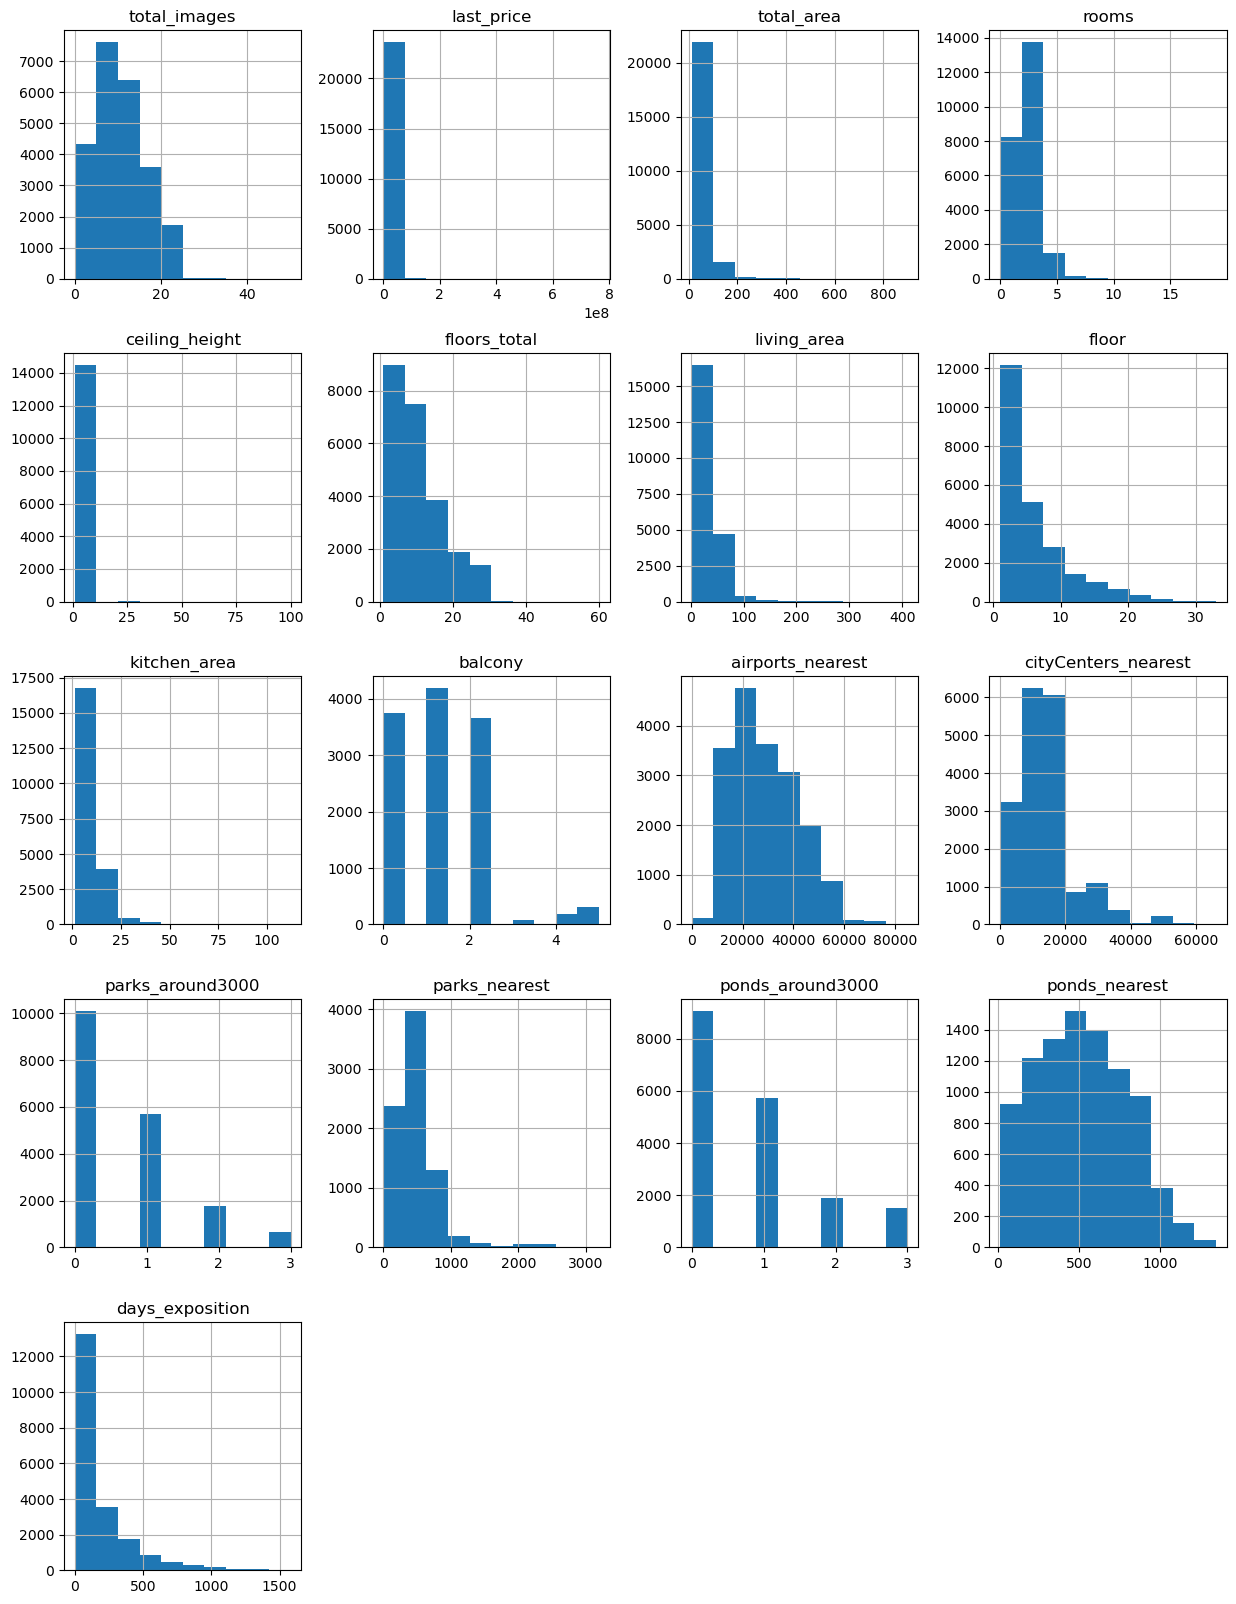

In [8]:
data.hist(figsize=(15,20))
plt.show()

### Предобработка данных

####  Приведем имена столбцов к единому стилю

In [9]:
data = data.rename(columns={'cityCenters_nearest' : 'city_centers_nearest',
                           'parks_around3000' : 'parks_around_3000',
                           'ponds_around3000' : 'ponds_around_3000'})
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


#### Определим наличие пропусков в данных и их количество

In [10]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

####  Обработаем пропуски в колонках, где это логически возможно

Изучим поподробнее состав в столбцах <mark>is_apartment</mark>, <mark>balcony</mark>, <mark>floors_total</mark>

In [11]:
data['is_apartment'].value_counts(dropna=False)

is_apartment
NaN      20924
False     2725
True        50
Name: count, dtype: int64

In [12]:
data['balcony'].value_counts(dropna=False)

balcony
NaN    11519
1.0     4195
0.0     3758
2.0     3659
5.0      304
4.0      183
3.0       81
Name: count, dtype: int64

In [13]:
data['floors_total'].value_counts(dropna=False)

floors_total
5.0     5788
9.0     3761
16.0    1376
12.0    1362
4.0     1200
10.0    1174
25.0    1075
6.0      914
17.0     833
3.0      668
7.0      592
14.0     553
18.0     505
24.0     469
8.0      390
2.0      383
15.0     365
23.0     352
19.0     339
22.0     286
20.0     271
13.0     229
11.0     203
27.0     164
21.0     158
26.0     124
NaN       86
1.0       25
35.0      24
28.0      21
36.0       3
34.0       1
60.0       1
29.0       1
33.0       1
52.0       1
37.0       1
Name: count, dtype: int64

Проанализировав данные можно сделать предположение, что причины возникновения пропусков в столбце <mark>is_apartment</mark> заключаются в том, что представленные квартиры не относятся к типу "апартаменты", и тогда пропущенные значения можно заменить на значение False, соответствующее тому, что данный объект недвижимости - не апартаменты. 

В столбце с данными о балконах, пропуски вероятно связаны с тем, что в данных квартирах нет балконов, поэтому пропущенные значения логичнее всего заменить нулями.

В столбце с данными о количестве этаже в доме, пропуски можно связать с тем, что это одноэтажные дома. Поэтому заполним пропуски значением 1. Даже если наше предположение ошибочно, 86 записей не должны сильно сдвинуть распределение.

In [14]:
data['is_apartment'] = data['is_apartment'].fillna(value=False)
print(len(data['is_apartment']))

23699


In [15]:
data['balcony'] = data['balcony'].fillna(value=0)
print(data['balcony'].value_counts(dropna=False))

balcony
0.0    15277
1.0     4195
2.0     3659
5.0      304
4.0      183
3.0       81
Name: count, dtype: int64


In [16]:
data = data.dropna(subset=['floors_total'])
data = data.reset_index(drop=True)
display(data)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,False,False,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,False,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,False,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,False,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,False,False,41.00,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23608,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,False,False,False,13.83,0.0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23609,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,False,False,False,8.50,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23610,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,False,False,False,NaN,0.0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23611,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,False,False,False,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


Изучим поподробнее состав в столбцах <mark>living_area</mark> и <mark>kitchen_area</mark> создав переменную data_area и поместив туда таблицу с данными о площадях и количества комнат в квартире

In [17]:
data_area = data.loc[:, ['total_area', 'living_area', 'kitchen_area', 'rooms', 'ceiling_height']]
display(data_area.tail(20))

,total_area,living_area,kitchen_area,rooms,ceiling_height
23593,35.00,NaN,NaN,1,NaN
23594,59.00,52.0,7.00,3,2.50
23595,43.00,29.0,6.00,2,2.50
23596,35.60,17.0,8.30,1,2.50
23597,62.80,45.5,5.50,4,2.50
23598,145.00,71.4,15.60,4,3.00
23599,31.00,17.3,5.60,1,2.50
23600,31.00,18.0,6.50,1,2.55
23601,39.00,20.0,11.00,1,NaN
23602,101.00,63.0,15.00,3,3.05


Проверим не являются ли пропуски в столбце <mark>living_area</mark> характерными для апартаментов или студий, где жилая площадь не так очевидна или пользователи просто не добавили данные

In [18]:
living_area = data[data['living_area'].isna()]

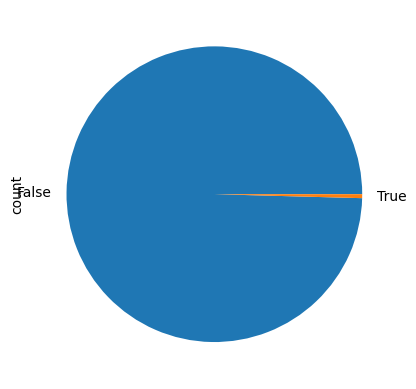

In [19]:
living_area['is_apartment'].value_counts().plot(kind='pie')
plt.show()

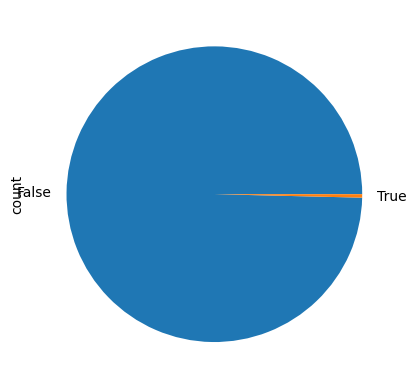

In [20]:
living_area['studio'].value_counts().plot(kind='pie')
plt.show()

Не похоже, что это так, поэтому заменим значения в столбце <mark>living_area</mark> медианными значениями. На этапе анализа данных проверим правильность такого решения

In [21]:
data['living_area'] = data['living_area'].fillna(value=(data['living_area'].median()))
print(len(data['living_area']))

23613


Аналогичным образом поступим с колонкой <mark>kitchen_area</mark> и заполним ее медианными значениями

In [22]:
data['kitchen_area'] = data['kitchen_area'].fillna(value=(data['kitchen_area'].median()))
print(len(data['kitchen_area']))

23613


Аналогичным образом поступим с колонкой <mark>ceiling_height</mark> и заполним ее медианными значениями. Более детальное рассмотрение этой колонки проведем не этапе обработки аномальных значений, так как в данных по этому столбцу явно присутствуют аномалии

In [23]:
data['ceiling_height'] = data['ceiling_height'].fillna(value=(data['ceiling_height'].median()))

In [24]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              48
airports_nearest         5532
city_centers_nearest     5509
parks_around_3000        5508
parks_nearest           15568
ponds_around_3000        5508
ponds_nearest           14552
days_exposition          3172
dtype: int64

#### Обработка дубликатов

In [25]:
data.duplicated().sum() #проверяем наличие явных дубликатов

0

In [26]:
#проверяем наличие неявных дубликатов поиском уникальных значений в столбце
print(len(data['locality_name'].sort_values().unique()))

365


Можно заметить, что поселок и посёлок дублируют значения, заменим их

In [27]:
#через replace заменим посёлок на послок
data['locality_name'] = data['locality_name'].str.replace('посёлок', 'поселок')
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Будогощь',
       'городской поселок Виллози', 'городской поселок Лесогорский',
       'городской поселок Мга', 'городской поселок Назия',
       'городской поселок Новоселье', 'городской поселок Павлово',
       'городской поселок Рощино', 'городской поселок Свирьстрой',
       'городской поселок Советский', 'городской поселок Фёд

Также обработаем повторы в названии населенных пунктов

In [28]:
data = data.replace({'locality_name' :
                    {'Никольское' : 'Село Никольское',
                     'городской поселок Советский' : 'поселок городского типа Советский',
                     'городской поселок Большая Ижора' : 'поселок городского типа Большая Ижора',
                     'городской поселок Лесогорский' : 'поселок городского типа Лесогорский',
                     'поселок Рябово' : 'поселок городского типа Рябово',
                     'деревня Кудрово' : 'Кудрово'}})

In [29]:
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Новая Ладога',
       'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво', 'Подпорожье',
       'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург', 'Светогорск',
       'Село Никольское', 'Сертолово', 'Сестрорецк', 'Сланцы',
       'Сосновый Бор', 'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Будогощь', 'городской поселок Виллози',
       'городской поселок Мга', 'городской поселок Назия',
       'городской поселок Новоселье', 'городской поселок Павлово',
       'городской поселок Рощино', 'городской поселок Свирьстрой',
       'городской поселок Фёдоровское', 'городской поселок Янино-1',
       'деревня Агалатово', 'деревня Аро', 'деревня Батово',


Далее удалим строки без названия населенного пункта

In [30]:
data = data.dropna(subset=['locality_name'])
print(len(data['locality_name'].unique()))

325


#### Изменение типов данных

<mark>first_day_exposition</mark> приведем к формату %Y-%m-%d, так как столбце нет данных о времени, только дата

In [31]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='mixed')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,False,False,11.0,2.0,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,30.0,9,False,False,False,9.1,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Изменим типы данных в столбцах <mark>balcony</mark>, <mark>last_price</mark>,  <mark>floors_total</mark> с float на int

In [32]:
for column in ['balcony', 'floors_total', 'last_price']:
    data[column] = data[column].astype('int')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000,159.0,2015-07-24,3,2.65,14,30.0,9,False,False,False,9.1,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Изменим типы данных в столбцах <mark>total_area</mark>, <mark>living_area</mark>,  <mark>ceiling_height</mark>, <mark>kitchen_area</mark>, <mark>airports_nearest</mark>, <mark>city_centers_nearest</mark>, <mark>parks_around_3000</mark>, <mark>parks_nearest</mark>, <mark>ponds_around_3000</mark>, <mark>ponds_nearest</mark>, <mark>days_exposition</mark> с float64 на float32

In [33]:
for column_2 in [
    'total_area',
    'living_area',
    'ceiling_height',
    'kitchen_area',
    'airports_nearest',
    'city_centers_nearest',
    'parks_around_3000',
    'parks_nearest', 
    'ponds_around_3000',
    'ponds_nearest',
    'days_exposition']:
    data[column_2] = data[column_2].astype('float32')

In [34]:
for column in ['balcony', 'floors_total', 'last_price']:
    data[column] = data[column].astype('int')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000,159.000000,2015-07-24,3,2.65,14,30.000000,9,False,False,False,9.1,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


#### Обработка аномальных значений

##### Обработка аномальных значений в столбце <mark>ceiling_height</mark>

In [35]:
data['ceiling_height'].describe()

count    23565.000000
mean         2.724530
std          0.991057
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

По описанию данных можно заметить, что минимальная высота потолков в <mark>ceiling_height</mark> составляет 1 м, максимальная - 100 м. Так же можно заметить, что встречаются потолки высотой 25 и 32 метров, что тоже определенно можно считать аномалией. Логично предположить, что на самом деле это вещественные значения 2.5 и 3.2 м, следовательно эти данный нужно поделить на 10

In [36]:
data.loc[data['ceiling_height'] >=5, 'ceiling_height'].count()

37

In [37]:
len(data['ceiling_height'])

23565

In [38]:
#Для значений больше 20 применим деление на 10
data.loc[data['ceiling_height'] >= 20, 'ceiling_height'] = data['ceiling_height'] / 10

In [39]:
#Проверим
data['ceiling_height'].describe().T

count    23565.000000
mean         2.698747
std          0.253628
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         14.000000
Name: ceiling_height, dtype: float64

In [40]:
len(data['ceiling_height'])

23565

Построим гистограмму

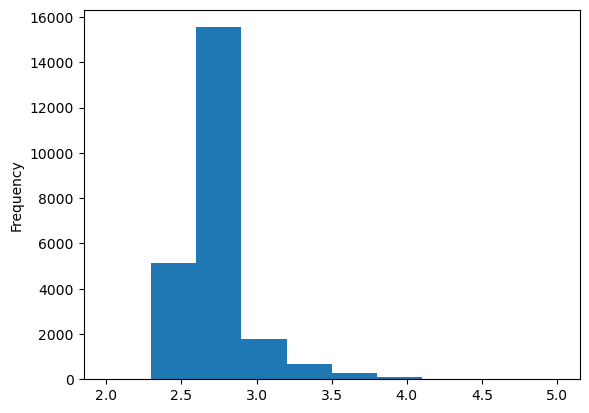

In [41]:
data['ceiling_height'].sort_values().plot(y='ceiling_height', kind = 'hist', bins = 10, range=(2,5))
plt.show()

Построим диаграмму размаха

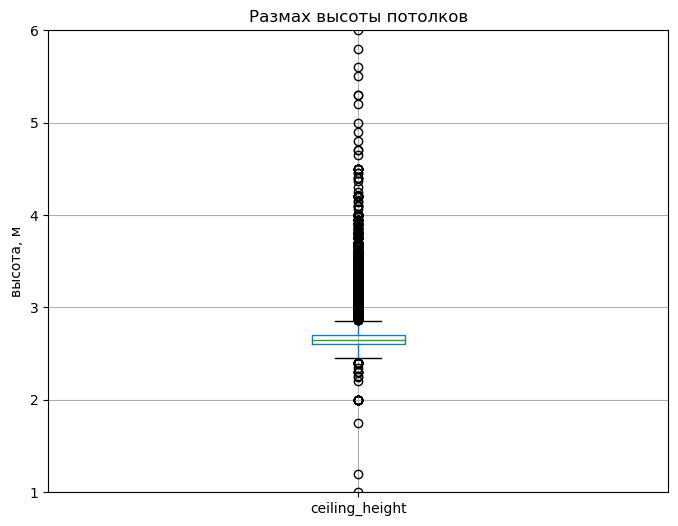

In [42]:
data.boxplot(column='ceiling_height', figsize=(8, 6))
plt.title('Размах высоты потолков')
plt.ylim(1, 6)
plt.ylabel('высота, м')
plt.show()

Из диаграммы размаха видно, что значения менее 2.5 и более 2.8 уже выбросы. Но в данных оставим значения с высотой потолков от 2.5 до 5 метров

In [43]:
data = data.query('2.5 <= ceiling_height <= 5')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23475 entries, 0 to 23612
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23475 non-null  int64         
 1   last_price            23475 non-null  int32         
 2   total_area            23475 non-null  float32       
 3   first_day_exposition  23475 non-null  datetime64[ns]
 4   rooms                 23475 non-null  int64         
 5   ceiling_height        23475 non-null  float32       
 6   floors_total          23475 non-null  int32         
 7   living_area           23475 non-null  float32       
 8   floor                 23475 non-null  int64         
 9   is_apartment          23475 non-null  bool          
 10  studio                23475 non-null  bool          
 11  open_plan             23475 non-null  bool          
 12  kitchen_area          23475 non-null  float32       
 13  balcony              

##### Обработка аномальных значений в столбце <mark>last_price</mark>

In [44]:
data['last_price'].describe()

count    2.347500e+04
mean     6.531831e+06
std      1.084748e+07
min      1.219000e+04
25%      3.420000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

В описании данных можно заметить, что стоимость квартиры в <mark>last_price</mark> составляет 12190р, что явно считается аномальным, максимальная - 763 000 000 р. Посмотрим гистограмму и диаграмму размаха, для возможности отсечения аномальных значений

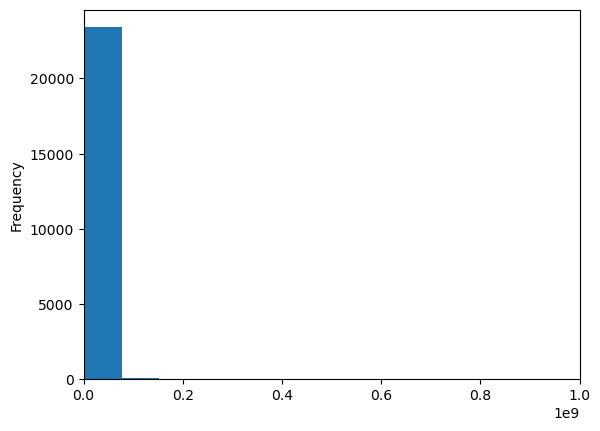

In [45]:
data['last_price'].sort_values().plot(y='last_price', kind='hist')
plt.xlim(0, 10e8)
plt.show()

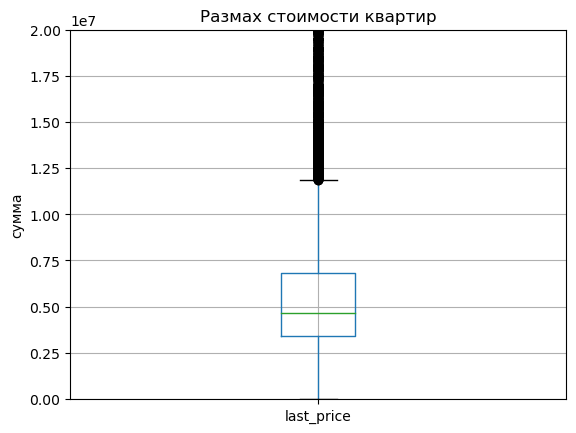

In [46]:
data.boxplot(column='last_price')
plt.title('Размах стоимости квартир')
plt.ylabel('сумма')
plt.ylim(-10000, 0.2e8)
plt.show()

Из диаграммы размаха видно, что значения меньше 12190 р и более 150 млн. уже выбросы, отбросим эти значения.

In [47]:
data = data.query('last_price > 12190 and last_price <= 150000000')

In [48]:
print(len(data))

23460


##### Обработка аномальных значений в столбце <mark>floors</mark>

In [49]:
data['rooms'].describe()

count    23460.000000
mean         2.068500
std          1.073991
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

Из сводной статистики видно, что максимальное количество комант составляет 19 комнат, это конечно вполне вероятно, но все таки для наших исследований будем рассматривать более часто встречающие варианты.

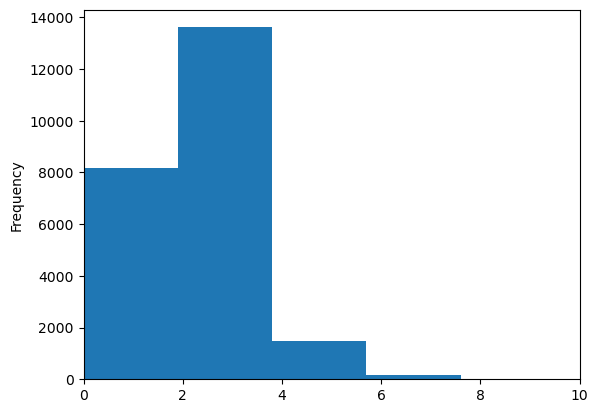

In [50]:
data['rooms'].sort_values().plot(y='rooms', kind='hist')
plt.xlim(0, 10)
plt.show()

Построим диаграмму размаха, чтобы убедиться, что редкие значения это все таки выбросы

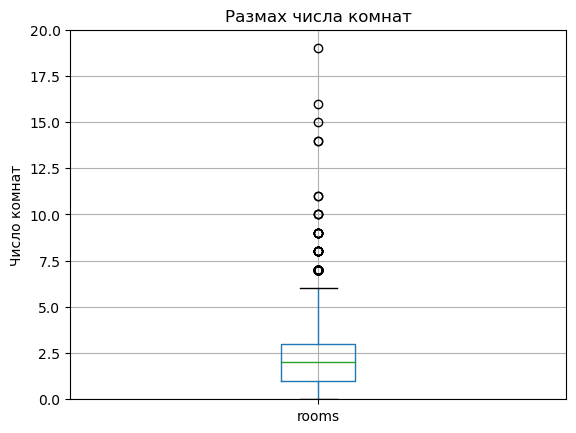

In [51]:
data.boxplot(column='rooms')
plt.title('Размах числа комнат')
plt.ylabel('Число комнат')
plt.ylim(0, 20)
plt.show()

Из диаграммы размаха видно, что выбросы все таки присутствуют и мы можем убрать их из датафрейма

In [52]:
data = data.query('rooms > 0 and rooms <= 10')

In [53]:
print(len(data))

23260


##### Обработка аномальных значений в столбце <mark>total_area</mark>

In [54]:
data['total_area'].describe()

count    23260.000000
mean        60.311287
std         34.008194
min         12.000000
25%         40.200001
50%         52.000000
75%         70.000000
max        631.200012
Name: total_area, dtype: float64

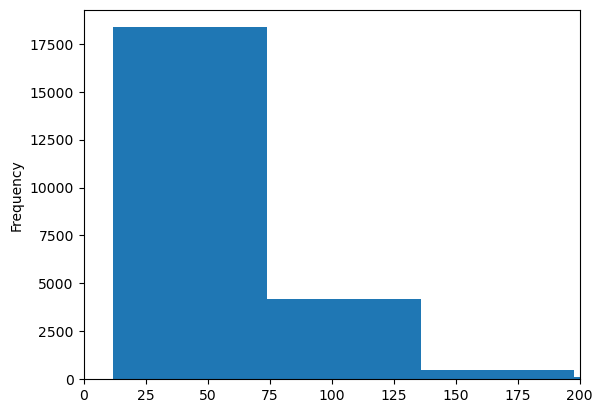

In [55]:
data['total_area'].sort_values().plot(y='total_area', kind='hist')
plt.xlim(0, 200)
plt.show()

Построим диаграмму размаха, чтобы убедиться, что редкие значения это все таки выбросы

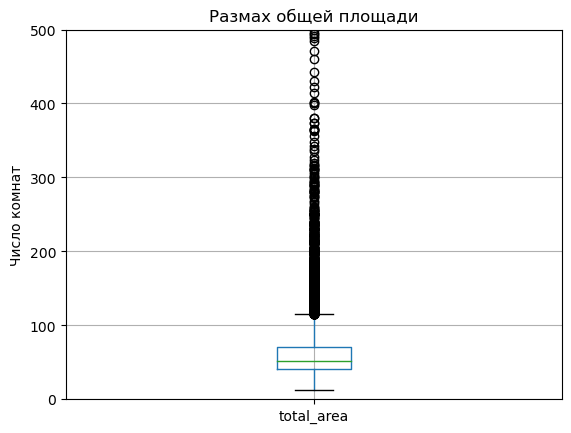

In [56]:
data.boxplot(column='total_area')
plt.title('Размах общей площади')
plt.ylabel('Число комнат')
plt.ylim(0, 500)
plt.show()

Из диаграммы размаха видно, что выбросы все таки присутствуют и мы можем убрать их из датафрейма

In [57]:
data = data.query('living_area <= 200')
print(len(data))

23238


#### Вывод по предобработке

На этапе предобработки данных: в  колонках с данными о:
- в  колонках с данными о типе квартиры (<mark>is_apartment</mark>), количестве балконов (<mark>balcony</mark>) были произведены логичные замены NaN значений;
- в колонке с данными о количестве этажей в доме (<mark>floors_total</mark>) NaN значения были удалены, так они составляют меньше 1 % от общих данных.
- в  колонках с данными о жилой площади (<mark>living_area</mark>) и площади кухни (<mark>kitchen_area</mark>) были произведены замены на соответствующие медианные значения;
- в колонке с данными о высоте потолков (<mark>ceiling_height</mark>) данные "почищены" от выбросов;
- колонка с данными о населенном пункте (<mark>locality_name</mark>) обработана от неявных дубликатов;
- колонка с данными о дате публикации (<mark>first_day_exposition</mark>) приведены к соответствующему типу данных "дата";
- в колонках с данными о количестве балконов (<mark>balcony</mark>), количестве этажей в доме (<mark>floors_total</mark>), цене на момент снятия с публикации (<mark>last_price</mark>) данные преобразованы из вещественных в целочисленные
- в колонках с данными о высоте потолков (<mark>ceiling_height</mark>), цене на момент снятия с публикации (<mark>last_price</mark>), количестве комнат <mark>rooms</mark>, общей площади <mark>total_area</mark> данные "почищены" от аномальных значений.
Всего из данных было отброшено не более 10% от изначального датафрейма


Данные в колонках расстояние до ближайшего аэропорта в метрах (м) <mark>airports_nearest</mark>, расстояние до центра города (м) <mark>cityCenters_nearest</mark>, число парков в радиусе 3 км <mark>parks_around3000</mark>, расстояние до ближайшего парка (м) <mark>parks_nearest</mark>, число водоёмов в радиусе 3 км <mark>parks_around3000</mark>, расстояние до ближайшего водоёма (м) <mark>ponds_nearest</mark> оставили с пропусками, так это картографические данные и логичной замены к ним подобрать довольно сложно.

Данные о том, сколько дней было размещено объявление (от публикации до снятия) <mark>days_exposition</mark> имеют не очень много пропусков, что скорее всего не скажется на анализе данных, поэтому пропуски в этой колонке оставим также не обработанными

### Добавление новых столбцов, необходимых для дальнейшего анализа

#### Добавим в данные столбец с ценой одного квадратного метра

In [58]:
data['price_square_meter'] =  data['last_price'] / data['total_area']
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,price_square_meter
0,20,13000000,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370
1,7,3350000,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.788947
2,10,5196000,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286
3,0,64900000,159.000000,2015-07-24,3,2.65,14,30.000000,9,False,False,False,9.1,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629
4,2,10000000,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000


#### Добавим в данные столбцы с указанием дня недели, месяца публикации, года публикации

In [59]:
#Добавляем столбец с днем недели публикации
data['exposition_weekday'] = data['first_day_exposition'].dt.weekday

#Добавляем столбец с месяцем публикации
data['exposition_month'] = data['first_day_exposition'].dt.month

#Добавляем столбец с годом публикации 
data['exposition_year'] = data['first_day_exposition'].dt.year

In [60]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,price_square_meter,exposition_weekday,exposition_month,exposition_year
0,20,13000000,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019
1,7,3350000,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.788947,1,12,2018
2,10,5196000,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015
3,0,64900000,159.000000,2015-07-24,3,2.65,14,30.000000,9,False,False,False,9.1,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7,2015
4,2,10000000,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018


#### Добавим в данные столбец floors_category с категоризацией по столбцу floors_total

In [61]:
#Напишем функцию для категоризации эатажности в доме
def get_floor_category(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'

In [62]:
# Добавляем столбец с категорией этажа квартиры
data['floor_category'] = data.apply(get_floor_category, axis=1)

In [63]:
data.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,price_square_meter,exposition_weekday,exposition_month,exposition_year,floor_category
4756,12,9990000,117.099998,2015-07-09,5,2.65,4,30.000000,4,False,False,False,9.1,0,Санкт-Петербург,21465.0,1404.0,1.0,378.0,2.0,103.0,946.0,85311.700514,3,7,2015,последний
21200,7,4750000,41.000000,2016-12-12,1,2.65,10,19.000000,5,False,False,False,11.0,0,Санкт-Петербург,51663.0,16965.0,0.0,NaN,0.0,NaN,698.0,115853.658537,0,12,2016,другой
512,7,5500000,51.400002,2018-09-06,2,2.60,14,29.100000,11,False,False,False,9.3,1,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0,107003.887874,3,9,2018,другой
21382,14,2300000,61.500000,2017-05-22,2,3.05,2,36.599998,2,False,False,False,7.8,1,Приозерск,NaN,NaN,NaN,NaN,NaN,NaN,162.0,37398.373984,0,5,2017,последний
12617,16,6590000,52.000000,2018-03-21,2,2.65,17,33.000000,6,False,False,False,8.3,1,Санкт-Петербург,34109.0,13977.0,0.0,NaN,0.0,NaN,14.0,126730.769231,2,3,2018,другой


#### Добавим в данные столбец с расстоянием до центра в километрах (округленным)

In [64]:
data['city_centers_nearest_km'] = round(data['city_centers_nearest'] / 1000)

In [65]:
data.head(4)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,price_square_meter,exposition_weekday,exposition_month,exposition_year,floor_category,city_centers_nearest_km
0,20,13000000,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,7,3350000,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.788947,1,12,2018,первый,19.0
2,10,5196000,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой,14.0
3,0,64900000,159.000000,2015-07-24,3,2.65,14,30.000000,9,False,False,False,9.1,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,другой,7.0


#### Вывод: Добавили дополнительные колонки, которые помогут нам в проведении анализа данных. 

### Изучение параметров объекта по отдельности

##### Изучим данные об общем площади

In [66]:
data['total_area'].describe()

count    23238.000000
mean        59.983829
std         32.176735
min         12.000000
25%         40.102499
50%         52.000000
75%         70.000000
max        631.000000
Name: total_area, dtype: float64

(0.0, 200.0)

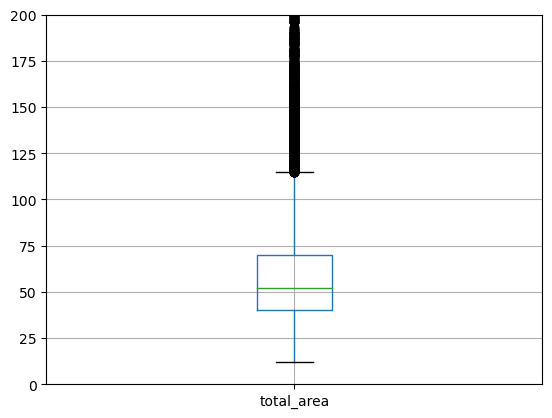

In [67]:
data.boxplot('total_area')
plt.ylim(0,200)

Промежуточные выводы по общим площадям:
- Большая часть значений лежит в диапазоне до 70 кв.м., что вполне реально
- Первый квартиль находится на уровне 40 кв.м
- Нижний "ус" упирается в 12 км.м., что тоже вполне справделиво, например для коммунальных квартир
- Верхний "ус" заканчиватеся на уровне около 115 км.м
- Все, что лежит за переделами "усов" будем считать выбросами

Так же, чтобы убедиться, что эти выбросы сильно влияют на распределение построим две гистограммы, одну по "грязным" данным, где участвуют все значения, и вторую по срезу данных в диапазоне от 12 до 115 км.м.

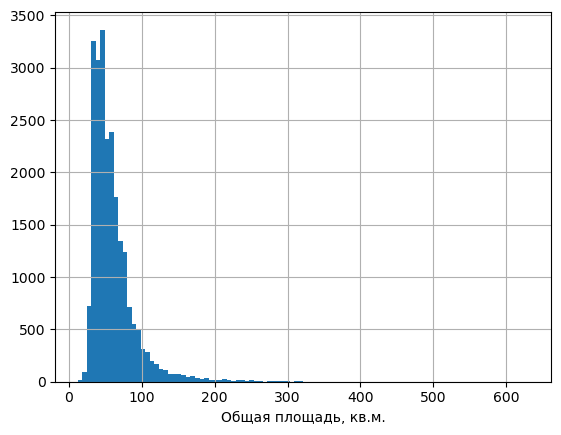

In [68]:
#Гисторграмма по "грязным данным"
data['total_area'].hist(bins=100)
plt.xlabel('Общая площадь, кв.м.')
plt.show()

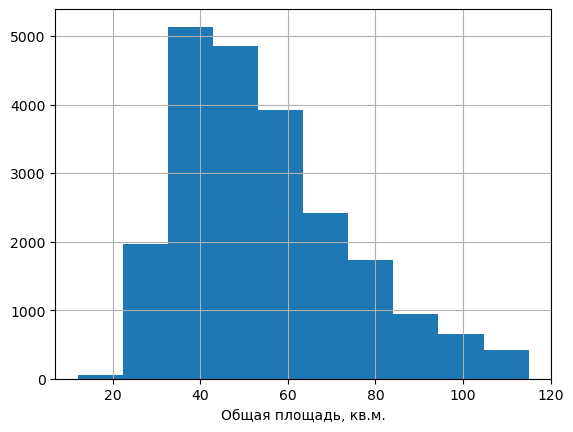

In [69]:
#Гисторграмма по срезу от 12 до 115 кв.м.
data.query('total_area >= 12 and total_area <= 115')['total_area'].hist()
plt.xlabel('Общая площадь, кв.м.')
plt.show()

Рассматриваемый диапазон примерно до 115 кв.м., исключая выбросы. Большая часть объектов недвижимости имеет площать от 30 до 65 кв.м. Самый распространенный вариант около 40-45 кв.м. Площадь объектов более 100 кв.м и менее 30 кв.м довольно редко.

##### Изучим данные о жилой площади

In [70]:
data['living_area'].describe()

count    23238.000000
mean        33.860104
std         19.188715
min          2.000000
25%         19.200001
50%         30.000000
75%         41.200001
max        200.000000
Name: living_area, dtype: float64

(0.0, 100.0)

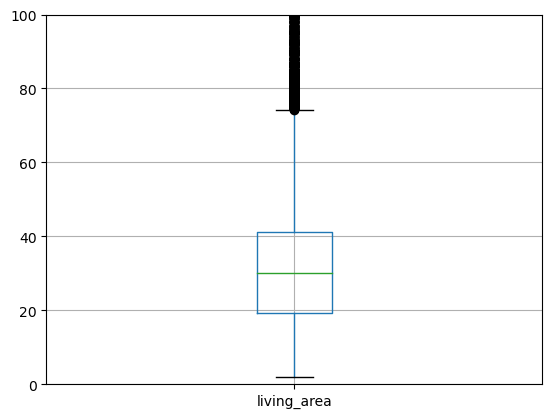

In [71]:
data.boxplot('living_area')
plt.ylim(0,100)

Промежуточные выводы по жилым площадям :
- Большая часть значений лежит в диапазоне до 41 кв.м., что вполне реально
- Первый квартиль находится на уровне 19 кв.м
- Нижний "ус" упирается в 2 км.м., что довольно мало, даже для очень маленьких квартир
- Верхний "ус" заканчиватеся на уровне около 75 км.м, что вполне реально
- Все, что лежит за переделами "усов" будем считать выбросами

Так же, чтобы убедиться, что эти выбросы сильно влияют на распределение построим две гистограммы, одну по "грязным" данным, где участвуют все значения, и вторую по срезу данных в диапазоне от 12 до 75 км.м.

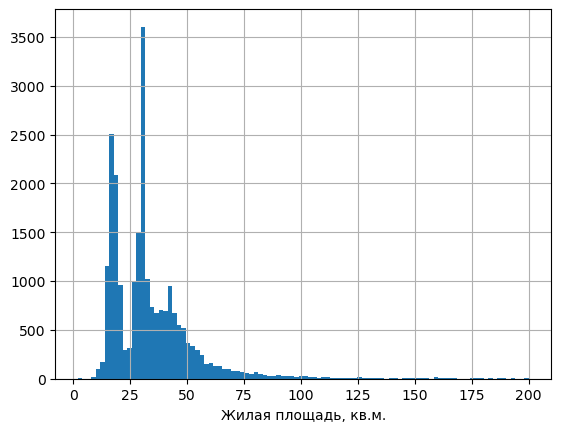

In [72]:
#Гисторграмма по "грязным данным"
data['living_area'].hist(bins=100)
plt.xlabel('Жилая площадь, кв.м.')
plt.show()

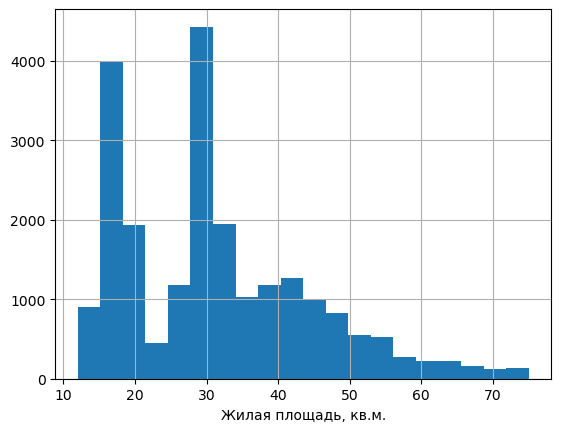

In [73]:
#Гистрограмма по срезу от 12 до 75 кв.м
data.query('living_area >= 12 and living_area <= 75')['living_area'].hist(bins=20)
plt.xlabel('Жилая площадь, кв.м.')
plt.show()

Рассматриваемый диапазон примерно до 75 кв.м., исключая выбросы. Большая часть объектов недвижимости имеет жилую площать от 15 до 30 кв.м. Самый распространенный вариант около 30 кв.м. Жилая площадь объектов более 60 кв.м встречается довольно редко.

##### Изучим данные о площади кухни

In [74]:
data['kitchen_area'].describe()

count    23238.000000
mean        10.390264
std          5.462980
min          1.300000
25%          7.300000
50%          9.100000
75%         11.500000
max        107.000000
Name: kitchen_area, dtype: float64

(0.0, 20.0)

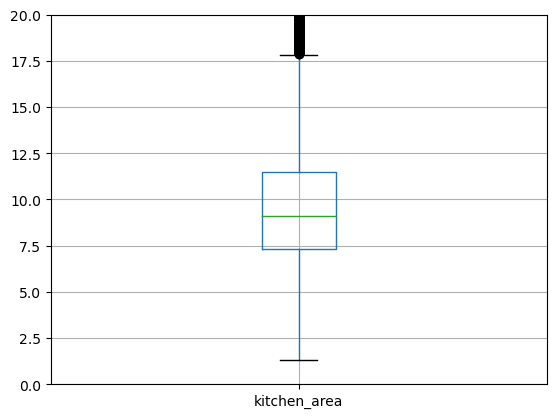

In [75]:
data.boxplot('kitchen_area')
plt.ylim(0,20)

Промежуточные выводы по жилым площадям :
- Большая часть значений лежит в диапазоне до 11 кв.м., что вполне реально
- Первый квартиль находится на уровне 7.5 кв.м
- Нижний "ус" упирается в 1.3 км.м., что довольно мало, даже для очень маленьких квартир
- Верхний "ус" заканчиватеся на уровне около 17.65 км.м, что вполне реально
- Все, что лежит за переделами "усов" будем считать выбросами

Так же, чтобы убедиться, что эти выбросы сильно влияют на распределение построим две гистограммы, одну по "грязным" данным, где участвуют все значения, и вторую по срезу данных в диапазоне от 5 до 18 кв.м.

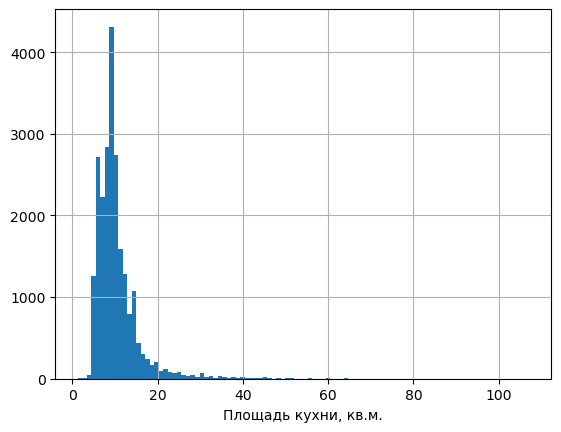

In [76]:
#Гисторграмма по "грязным данным"
data['kitchen_area'].hist(bins=100)
plt.xlabel('Площадь кухни, кв.м.')
plt.show()

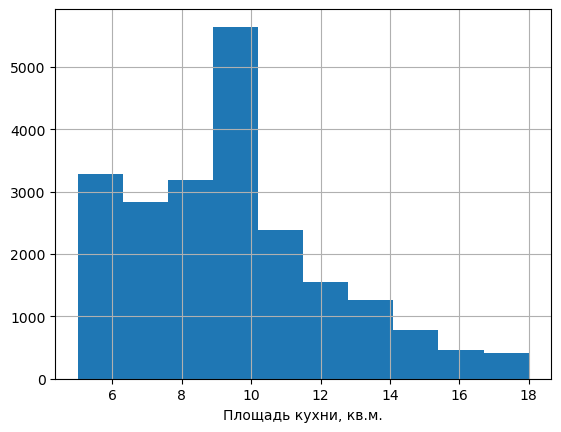

In [77]:
#Гистограмма по срезу от 5 до 18 кв.м
data.query('kitchen_area >= 5 and kitchen_area <= 18')['kitchen_area'].hist()
plt.xlabel('Площадь кухни, кв.м.')
plt.show()

Рассматриваемый диапазон примерно до 18 кв.м., исключая выбросы. Большая часть объектов недвижимости имеет площать кухни от 9 до 11 кв.м. Самый распространенный вариант около 9 кв.м. Площадь кухни объектов более  16 кв.м встречается довольно редко.

##### Изучим данные о цене

Здесь можно предположить, что цены на квартиры будут прилично отличаться. В г. Санкт-Петербург очевидно будет самое дорогое жилье, тогда как в деревнях и поселках - дешевле.

In [78]:
data['last_price'].describe()

count    2.323800e+04
mean     6.317290e+06
std      7.043169e+06
min      4.300000e+05
25%      3.450000e+06
50%      4.650000e+06
75%      6.800000e+06
max      1.500000e+08
Name: last_price, dtype: float64

(-1000000.0, 14000000.0)

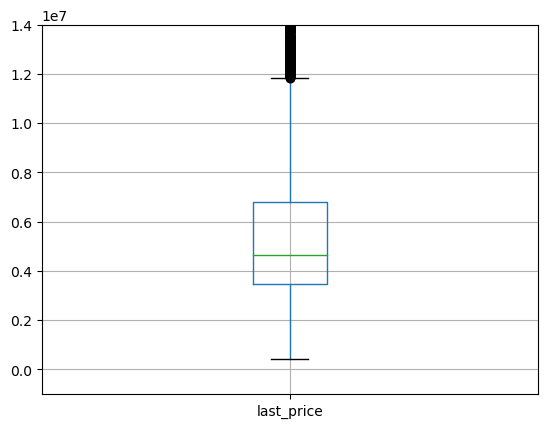

In [79]:
data.boxplot('last_price')
plt.ylim(-1e+06, 1.4e+07)

Промежуточные выводы по ценам на квартиры:
- Большая часть значений лежит в диапазоне до 7 млн.руб, что вполне правдоподобно
- Первый квартиль находится на уровне около 3.5 млн
- Нижний "ус" практически упирается в 0. После удаления строки, где минимальная цена квартиры составляла 12190рублей, минимальное значение теперь составляет 430 000, что может быть вполне справделивым для деревни.
- Верхний "ус" упирается в значение 12 млн. Остальные значения будем считать выбросами.

Так же, чтобы убедиться, что эти выбросы сильно влияют на распределение построим две гистограммы, одну по "грязным" данным, где участвуют все значения, и вторую по срезу данных в диапазоне от 430 тыс до 12 млн.

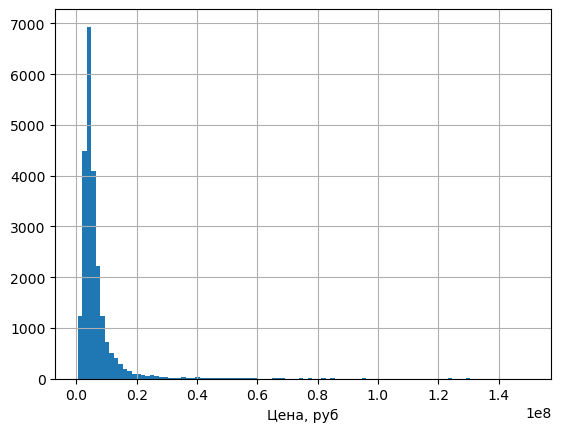

In [80]:
#Гисторграмма по "грязным данным"
data['last_price'].hist(bins=100)
plt.xlabel('Цена, руб')
plt.show()

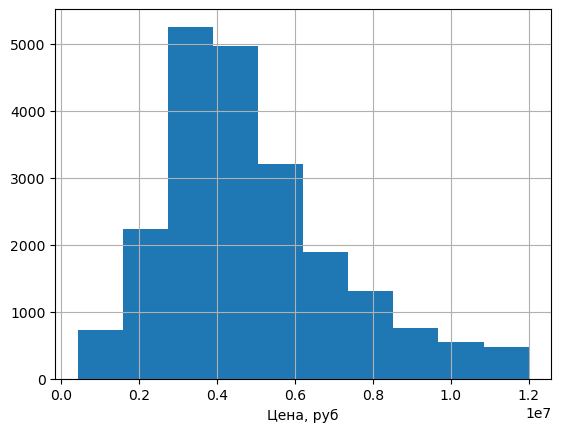

In [81]:
#Гисторграмма по срезу от 430 тыс до 12 млн

data.query('last_price >= 430000 and last_price <= 12000000')['last_price'].hist()
plt.xlabel('Цена, руб')
plt.show()

Рассматриваем диапазон до примерно 12 млн руб., исключая выбросы. Большинство объектов недвижимости имеют цену в пределах от 3 до 5 млн. руб.. Самый распространенный вариант - около 3.5 млн.руб.. Вариантов с ценой более 10 млн немного

##### Изучим данные о количестве комнат

In [82]:
data['rooms'].describe()

count    23238.000000
mean         2.077933
std          1.030746
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: rooms, dtype: float64

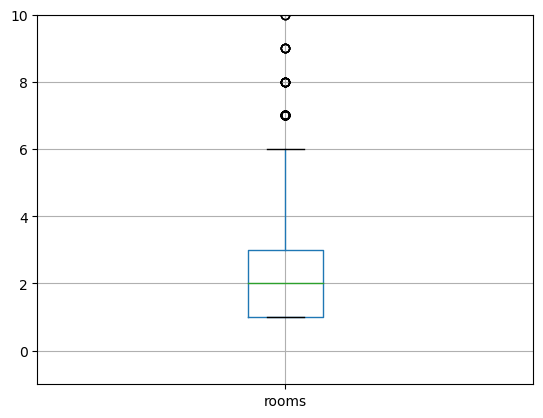

In [83]:
data.boxplot('rooms')
plt.ylim(-1, 10)
plt.show()

Промежуточные выводы по количеству комнат в объектах недвижимости
- Большая часть значения лежит в диапазоне до 3 комнат, что выглядит правдоподобно
- Первый квартиль находится на уровне 1 комнаты
- Нижний "ус" упирается в 0, минимальное значение. Скорее всего это говорит об ошибке в данных
- Верхний "ус" заканчивается около 6 комнат
- Выбросы лежат за ориентировочной границей нормального распределения

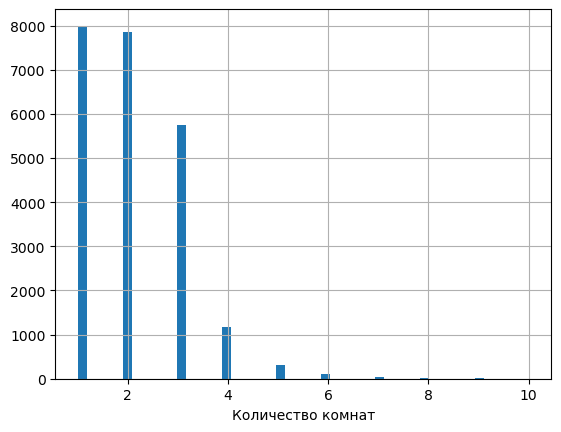

In [84]:
#Гисторграмма по "грязным данным"
data['rooms'].hist(bins=50)
plt.xlabel('Количество комнат')
plt.show()

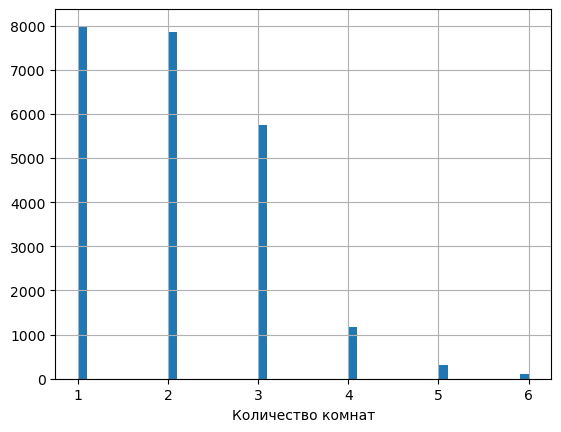

In [85]:
#Гисторграмма по срезу от 1 до 6 комнат
data.query('rooms >= 1 and rooms <= 6')['rooms'].hist(bins=50)
plt.xlabel('Количество комнат')
plt.show()

Вывод здесь практически однозначный, что чаще всего продаются однокомнатные, двухкомнатные и трехкомнатные квартиры.

##### Изучим данные о высоте потолков

In [86]:
data['ceiling_height'].describe()

count    23238.000000
mean         2.696075
std          0.213283
min          2.500000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.000000
Name: ceiling_height, dtype: float64

Данные о высоте потолков были обработаны на этапе предобработки данных, поэтому можн сразу строить гистограмму

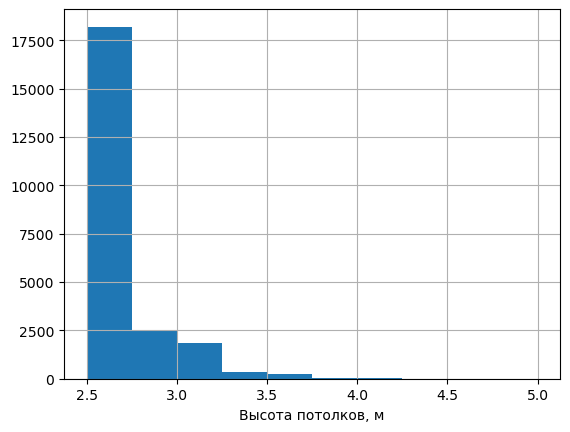

In [87]:
data['ceiling_height'].hist(bins=10)
plt.xlabel('Высота потолков, м')
plt.show()

Вывод здесь практически однозначный, что чаще всего продаются объекты недвижимости, в которых высота потолков составляет от 2.5 до 2.75 м.

##### Изучим данные об этаже квартиры

In [88]:
data['floor'].describe()

count    23238.000000
mean         5.860315
std          4.855969
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

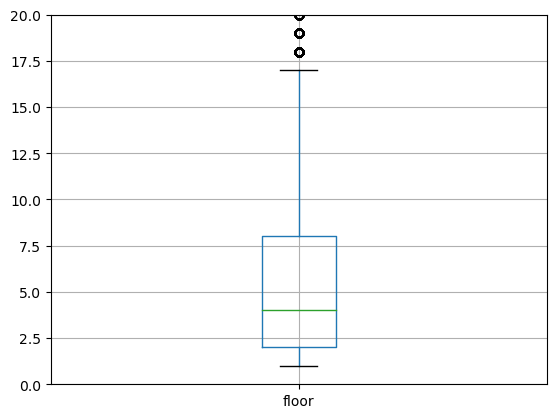

In [89]:
data.boxplot('floor')
plt.ylim(0,20)
plt.show()


Промежуточные выводы по этажу
- Большая часть значения лежит в диапазоне до 8 этажа, что вполне нормально
- Первый квартиль находится на уровне 2 этажей
- Нижний "ус" упирается в 1, минимальное значение, что вполне реально, ведь речь может идти об одноэтажном доме.
- Верхний "ус" заканчивается около 17 этажей
- Все что лежит за пределами "усов" будем считаь выбросами

Так же, чтобы убедиться, что эти выбросы сильно влияют на распределение построим две гистограммы, одну по "грязным" данным, где участвуют все значения, и вторую по срезу данных в диапазоне от 1 до 17 этажей.

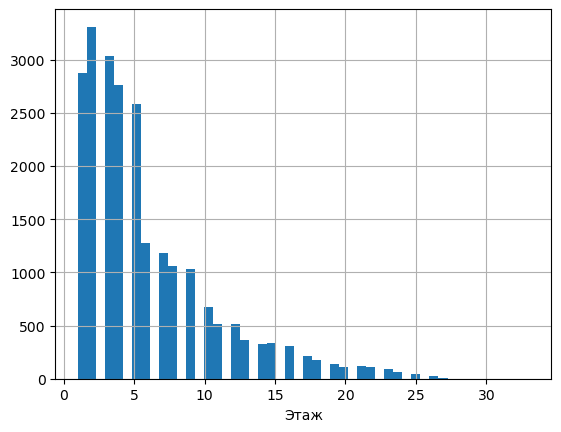

In [90]:
#Гисторграмма по "грязным данным"
data['floor'].hist(bins=50)
plt.xlabel('Этаж')
plt.show()

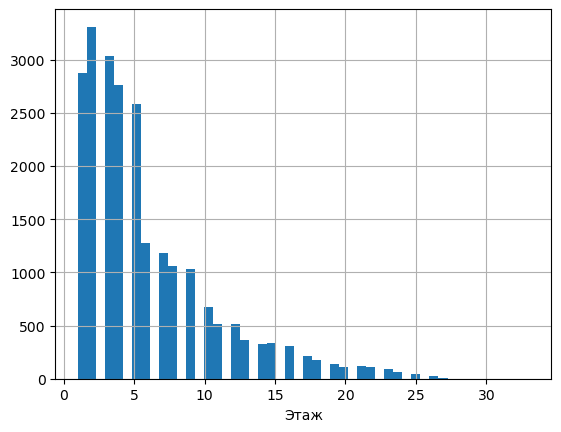

In [91]:
#Гисторграмма по всем этажам
data['floor'].hist(bins=50)
plt.xlabel('Этаж')
plt.show()

Большинство объектов недвижимости расположены с 1 по 5 этаж. Реже представлены варианты с 6 по 9 этажи.

##### Изучим данные о типе этажа квартиры

In [92]:
data['floor_category'].value_counts()

floor_category
другой       17082
последний     3282
первый        2874
Name: count, dtype: int64

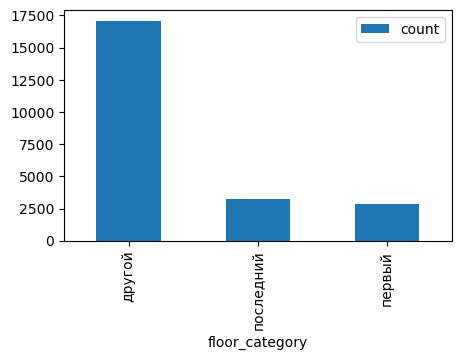

In [93]:
data['floor_category'].value_counts().plot.bar(figsize=(5, 3), legend=True)
plt.show()

Видно, что объекты недвижимости, расположенные на первом и последним этажах имеют примерно одинаковые значения и их доля не столь велика. В основном объекты расположены на этажах между первым и последним

##### Изучим данные об общем количестве этажей в доме 

In [94]:
data['floors_total'].describe()

count    23238.000000
mean        10.641234
std          6.571517
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

(0.0, 50.0)

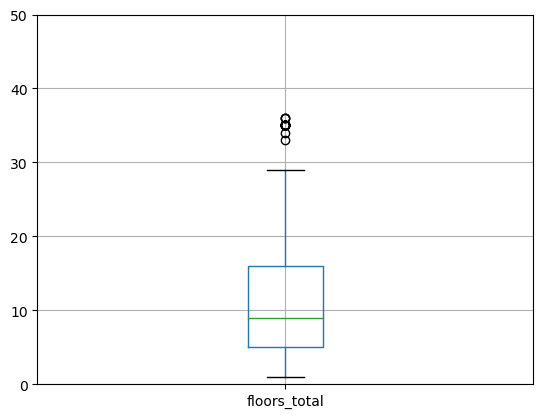

In [95]:
data.boxplot('floors_total')
plt.ylim(0,50)

Промежуточные выводы по этажу
- Большая часть значения лежит в диапазоне до 16 этажа, что вполне нормально
- Первый квартиль находится на уровне 5 этажей
- Нижний "ус" упирается в 1, минимальное значение, что вполне реально, ведь речь может идти об одноэтажном доме.
- Верхний "ус" заканчивается около 29 этажей
- Все что лежит за пределами "усов" будем считаь выбросами

Так же, чтобы убедиться, что эти выбросы сильно влияют на распределение построим две гистограммы, одну по "грязным" данным, где участвуют все значения, и вторую по срезу данных в диапазоне от 1 до 28 этажей.

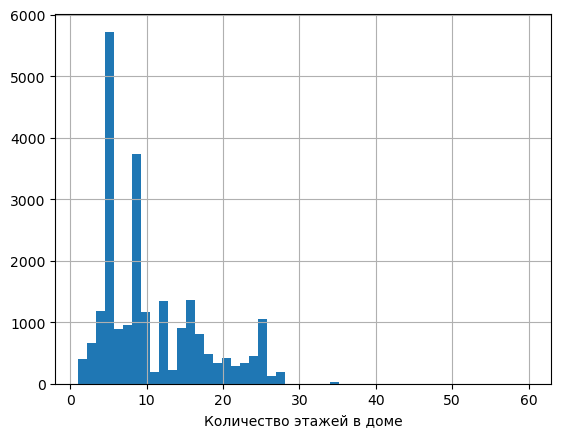

In [96]:
#Гисторграмма по "грязным данным"
data['floors_total'].hist(bins=50)
plt.xlabel('Количество этажей в доме')
plt.show()

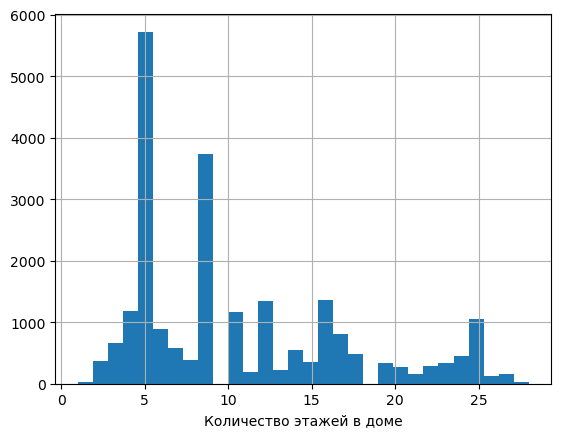

In [97]:
#Гисторграмма по срезу от 1 до 28 этажей
data.query('floors_total >= 1 and floors_total <= 28')['floors_total'].hist(bins=30)
plt.xlabel('Количество этажей в доме')
plt.show()

Как видно из полученной гистограммы, большинство объектов недвижимости - это 5-ти этажки и 9-ти этажки

##### Изучим данные о расстоянии до центра города в метрах

In [98]:
data['city_centers_nearest'].describe()

count    17847.000000
mean     14219.185547
std       8628.625977
min        181.000000
25%       9272.500000
50%      13107.000000
75%      16293.000000
max      65968.000000
Name: city_centers_nearest, dtype: float64

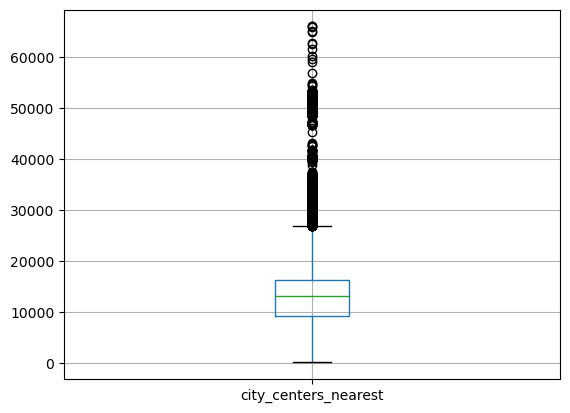

In [99]:
data.boxplot('city_centers_nearest')
plt.show()

Промежуточные выводы по этажу

- Большая часть значения лежит в диапазоне до 16 км, что вполне нормально для большого города, так как объект может распологаться довольно далеко от центра
- Первый квартиль находится на уровне 9.5 км
- Нижний "ус" упирается в 181 м, минимальное значение, что вполне реально, может быть этот объект недвижимости находится прямо.  в центре. Однако это очень редкий случай, поэтому далее гистограмму будем строить в радиусе от 1,5 км
- Верхний "ус" заканчивается около 27 км
- Все что лежит за пределами "усов" будем считаь выбросами

Так же, чтобы убедиться, что эти выбросы сильно влияют на распределение построим две гистограммы, одну по "грязным" данным, где участвуют все значения, и вторую по срезу данных в диапазоне от 1,5 км м до 27 км.

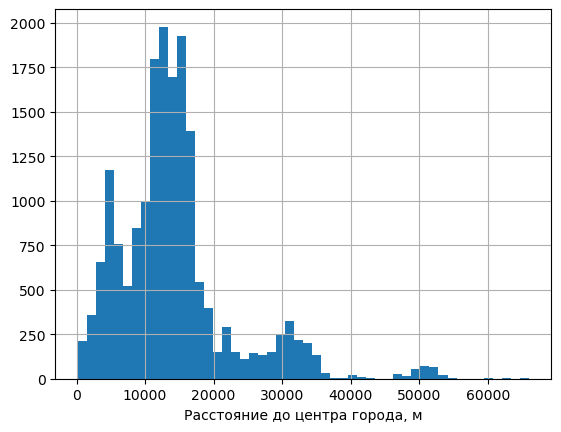

In [100]:
#Гисторграмма по "грязным данным"
data['city_centers_nearest'].hist(bins=50)
plt.xlabel('Расстояние до центра города, м')
plt.show()

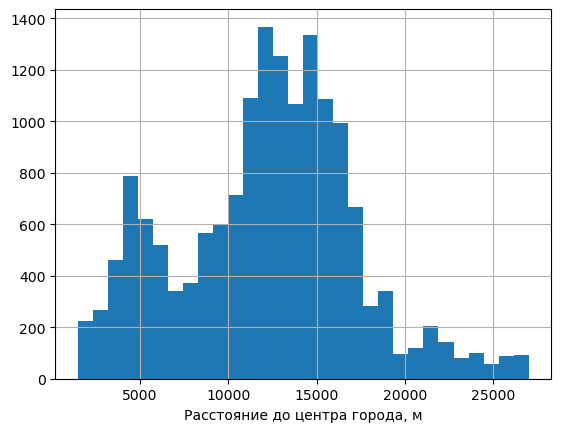

In [101]:
#Гисторграмма по срезу от 1,5 км до 27 км
data.query('city_centers_nearest >= 1500 and city_centers_nearest <= 27000')['city_centers_nearest'].hist(bins=30)
plt.xlabel('Расстояние до центра города, м')
plt.show()

Большинство объектов недвижимости расположены на удалении 12-15 км от центра. Остальные варианты представлены реже.

##### Изучим данные о расстоянии до ближайшего аэропорта

In [102]:
data['airports_nearest'].describe()

count    17826.000000
mean     28836.591797
std      12642.801758
min          0.000000
25%      18574.000000
50%      26794.500000
75%      37319.750000
max      84869.000000
Name: airports_nearest, dtype: float64

In [103]:
#В данных присутствуют нулевые значения, уберем их
data = data.query('airports_nearest != 0')

In [104]:
data['airports_nearest'].describe()

count    17825.000000
mean     28838.208984
std      12641.278320
min       6450.000000
25%      18574.000000
50%      26798.000000
75%      37322.000000
max      84869.000000
Name: airports_nearest, dtype: float64

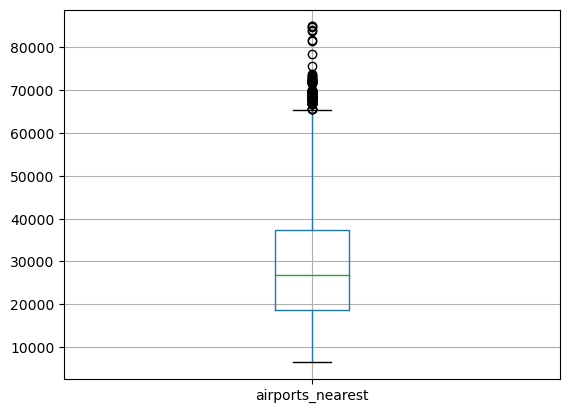

In [105]:
data.boxplot('airports_nearest')
plt.show()

Промежуточные выводы по этажу

- Большая часть значения лежит в диапазоне до 37 км, что вполне нормально 
- Первый квартиль находится на уровне 18 км
- Нижний "ус" упирается в 6,5 км, минимальное значение, что вполне реально
- Верхний "ус" заканчивается около 65 км
- Все что лежит за пределами "усов" будем считаь выбросами

Так же, чтобы убедиться, что эти выбросы сильно влияют на распределение построим две гистограммы, одну по "грязным" данным, где участвуют все значения, и вторую по срезу данных в диапазоне от 6,5 км до 65 км.

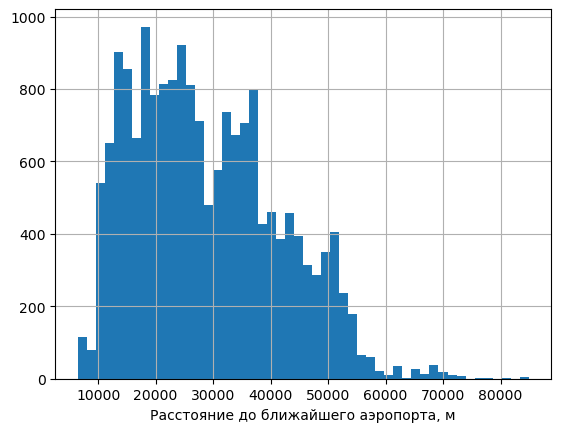

In [106]:
#Гисторграмма по "грязным данным"
data['airports_nearest'].hist(bins=50)
plt.xlabel('Расстояние до ближайшего аэропорта, м')
plt.show()

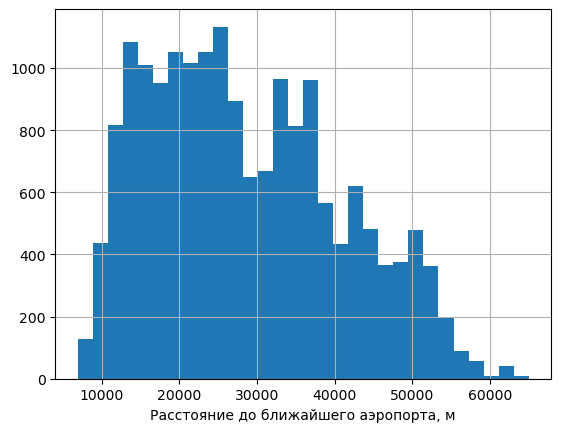

In [107]:
#Гисторграмма по срезу от 1,5 км до 27 км
data.query('airports_nearest >= 6500 and airports_nearest <= 65000')['airports_nearest'].hist(bins=30)
plt.xlabel('Расстояние до ближайшего аэропорта, м')
plt.show()

Большая часть объектов недвижимости удалена от аэропорта на 15-25 км. Ближайший к аэропорту объект находится на расстоянии 6,5 км.

##### Изучим данные о расстоянии до ближайшего парка


In [108]:
data['parks_nearest'].describe()

count    7934.000000
mean      490.615692
std       342.562103
min         1.000000
25%       288.000000
50%       453.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

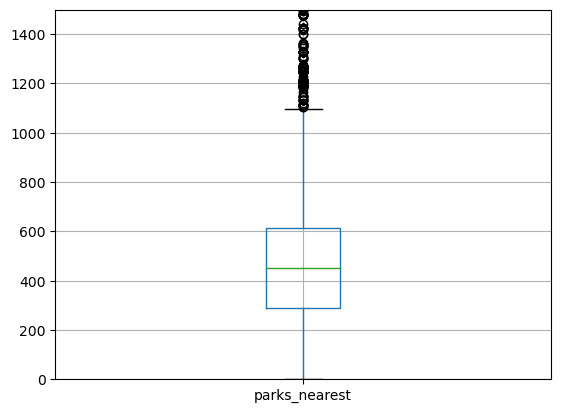

In [109]:
data.boxplot('parks_nearest')
plt.ylim(0, 1500)
plt.show()

Промежуточные выводы по этажу

- Большая часть значения лежит в диапазоне до 612 м, что вполне нормально 
- Первый квартиль находится на уровне 287 м
- Нижний "ус" упирается в 1 м, минимальное значение, что скорее всего является ошибкой в данных, так как парк не может находится на расстоянии 1 м
- Верхний "ус" заканчивается около 1100 м
- Все что лежит за пределами "усов" будем считаь выбросами

Так же, чтобы убедиться, что эти выбросы сильно влияют на распределение построим две гистограммы, одну по "грязным" данным, где участвуют все значения, и вторую по срезу данных в диапазоне от 0 м до 1100 м.

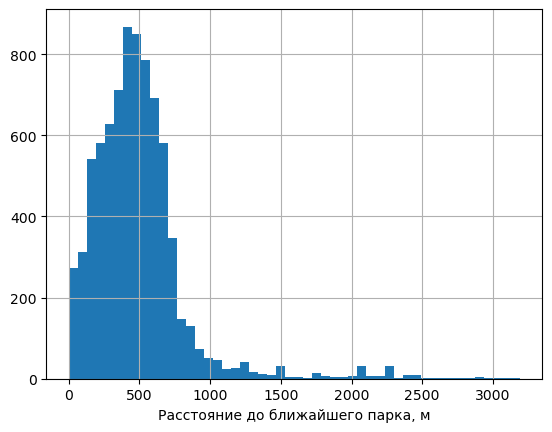

In [110]:
#Гисторграмма по "грязным данным"
data['parks_nearest'].hist(bins=50)
plt.xlabel('Расстояние до ближайшего парка, м')
plt.show()

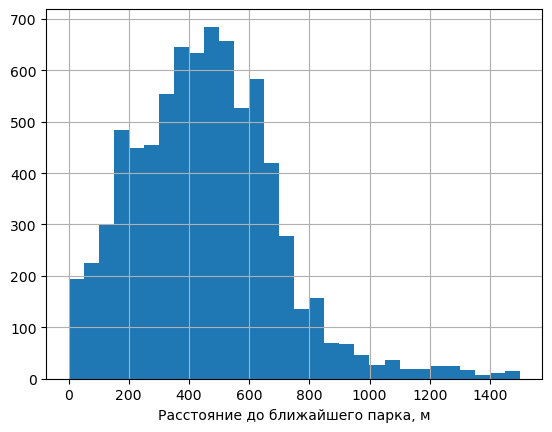

In [111]:
#Гисторграмма по срезу от 0 м до 1,5 км
data.query('parks_nearest > 0 and parks_nearest <= 1500')['parks_nearest'].hist(bins=30)
plt.xlabel('Расстояние до ближайшего парка, м')
plt.show()

Большинство объектов недвижимости расположены на удалении от ближайшего парка на расстоянии 400-600 м.

##### Изучим данные о дне и месяце публикации данных


In [112]:
# Посмотрим описание данных о дне
data['exposition_weekday'].describe()

count    23237.000000
mean         2.566252
std          1.788302
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: exposition_weekday, dtype: float64

In [113]:
# Посмотрим кол-во объявлений по каждому дню недели
data['exposition_weekday'].value_counts().sort_values()

exposition_weekday
6    1656
5    1897
0    3550
2    3894
4    3917
1    4107
3    4216
Name: count, dtype: int64

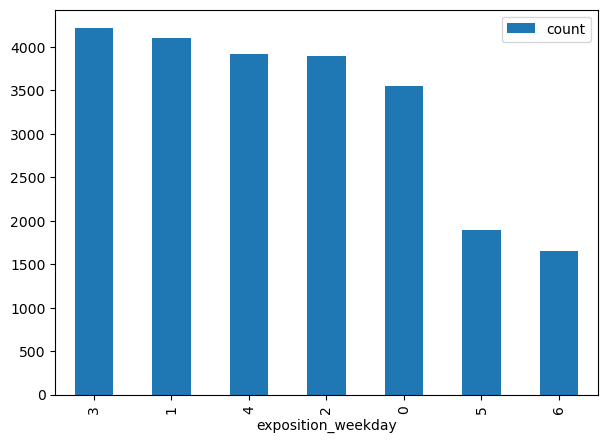

In [114]:
# Отобразим это на графике
data['exposition_weekday'].value_counts().plot.bar(figsize=(7, 5), legend=True)
plt.show()

По графику видно, что чаще всего объявления публиковали в будние дни в середине недели. Реже в выходные дни

In [115]:
# Посмотрим описание данных о месяце
data['exposition_month'].describe()

count    23237.000000
mean         6.395748
std          3.492107
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: exposition_month, dtype: float64

In [116]:
# Посмотрим кол-во объявлений по каждому месяцу
data['exposition_month'].value_counts().sort_values()

exposition_month
5     1244
1     1467
12    1614
7     1662
8     1708
6     1734
9     1939
10    2079
11    2316
4     2327
3     2542
2     2605
Name: count, dtype: int64

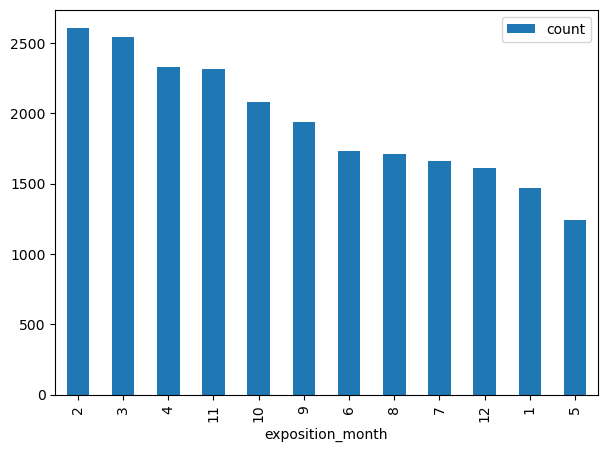

In [117]:
# Отобразим это на графике
data['exposition_month'].value_counts().plot.bar(figsize=(7, 5), legend=True)
plt.show()

По графику видно, что чаще всего объявления публиковали после январских праздников, в феврале. Наименьшие показатели в январе и мае. Можно предположить, что это из-за большого кол-ва выходных и праздничных дней

##### Вывод: Мы получили представление о типичном объекте недвижимости из исходных данных: квартира с 1 или 2 комнатами, 5-ти или 9-ти этажка (с квартирой с 1 по 5 этаж), общей площадью около 45 кв.м., площадью кухни около 9 кв.м, с высотой потолков 2,5-2,7 м, стоимостью около 3.5 млн.руб, расположенной на удалении от центра на расстоянии 12-15 км, от аэропорта на расстоянии 15-25 км, до ближайшего парка около 500 метров.

#### Изучение скорости продажи квартир по столбцу <mark>days_exposition</mark>

Для начала построим гистограмму

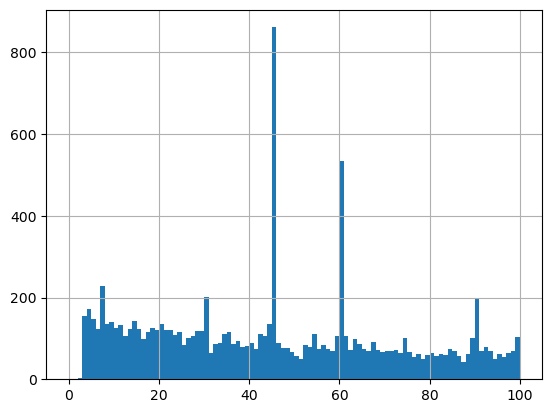

In [118]:
data['days_exposition'].hist(bins=100, range=(0,100))
plt.show()

Из полученной гистограммы видно, что чаще всего квартиры продаются за 45 и 60 дней. Но тут стоит отметить, что возможно за это время квартира не была продана, а просто истек срок публикации объявления на сайте продажи.

Получим описательную статистику с помощью метода describe()

In [119]:
data['days_exposition'].describe()

count    20099.000000
mean       181.229767
std        219.945938
min          1.000000
25%         45.000000
50%         96.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Из описания видно, что среднее время продажи квартиры составляет 181 день, а медианное - 95 дней. Максимальное значение - 1580 дней. Среднее значение в 2 раза больше медианного, а стандартное отклонение выше среднего, что говорит о большом количестве выбросов. Чтобы в этом убедить построим диаграмму размаха

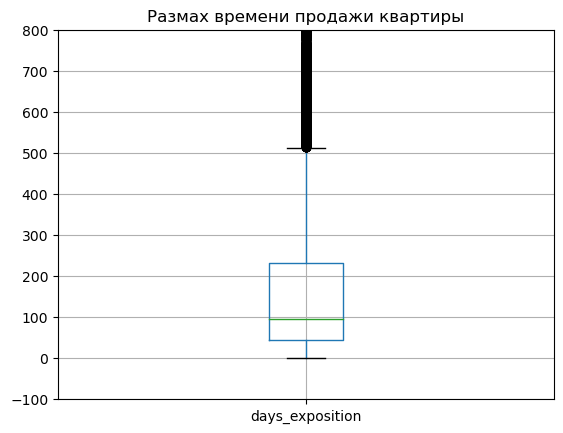

In [120]:
data.boxplot('days_exposition')
plt.title('Размах времени продажи квартиры')
plt.ylim(-100, 800)
plt.show()

- Большая часть значения лежит в диапазоне до 231 дней, что кажется вполне нормальным, некоторые объекты недвижимости действительно могут довольно долго продаваться
- Первый квартиль находится на уровне 45 дней
- Нижний "ус" упирается в 1 день, минимальное значение
- Верхний "ус" заканчивается около 510 дней
- Все что лежит за пределами "усов" будем считаь выбросами

Построим гистограмму без выбросов

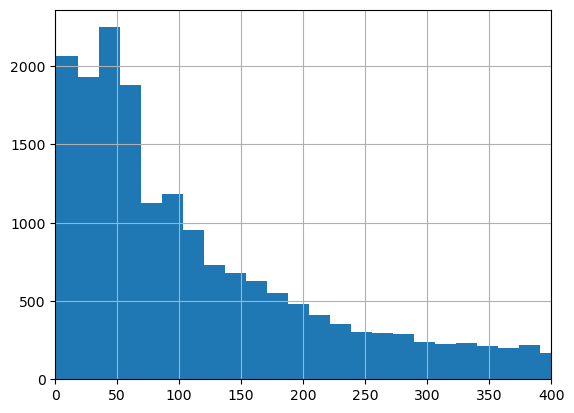

In [121]:
data.query('days_exposition <= 510')['days_exposition'].hist(bins=30)
plt.xlim(0,400)
plt.show()

"Почистим" данные от выбросов для дальнейших исследований

In [122]:
data_good_day = data.query('days_exposition <= 510')
len(data) - len(data_good_day)

4787

Убрали из датафрейма 4837 строк, которые содержали выбросы по времени продажи объекта. 
Оценка времени продажи показала:
- быстрая продажа - до 45 дней,
- нормальная продажа - от 45 до 231 дней,
- долгая продажа - от 231 до 510 дней.
- Продажи после 510 дней - выбросы

#### Изучение факторов влияющих на общую стоимость объекта

In [123]:
data_good_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18450 entries, 1 to 23609
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             18450 non-null  int64         
 1   last_price               18450 non-null  int32         
 2   total_area               18450 non-null  float32       
 3   first_day_exposition     18450 non-null  datetime64[ns]
 4   rooms                    18450 non-null  int64         
 5   ceiling_height           18450 non-null  float32       
 6   floors_total             18450 non-null  int32         
 7   living_area              18450 non-null  float32       
 8   floor                    18450 non-null  int64         
 9   is_apartment             18450 non-null  bool          
 10  studio                   18450 non-null  bool          
 11  open_plan                18450 non-null  bool          
 12  kitchen_area             18450 non-nu

In [124]:
# Создадим список с параметрами для проверки
param_corr = ['last_price', 
              'total_area',
              'living_area',
              'kitchen_area',
              'rooms'] 

Построим матрицу корреляции

In [125]:
matrix_corr = data_good_day[param_corr].corr()

In [126]:
display(matrix_corr)

,last_price,total_area,living_area,kitchen_area,rooms
last_price,1.000000,0.724594,0.575286,0.508012,0.429438
total_area,0.724594,1.000000,0.869864,0.538140,0.770928
living_area,0.575286,0.869864,1.000000,0.346971,0.830136
kitchen_area,0.508012,0.538140,0.346971,1.000000,0.211108
rooms,0.429438,0.770928,0.830136,0.211108,1.000000


Видно, что наибольшая положительная линейная связь между стоимостью квартиры и ее площадью. Зависимость прямопропорциональная - чем больше стоимость квартиры, тем больше ее площадь. Положительная линейная связь отмечается также между стоимостью квартиры и количеством комнат. Связь отличается примерно в 2 раза от связи между стоимостью квартиры и площадью. Соответственно чем количество комнат больше, тем больше стоимость квартиры. Между стоимостью квартиры и днем недели, месяцем или годом размещения объявления также отсутствует линейная связь, корреляция близкая к нулю.

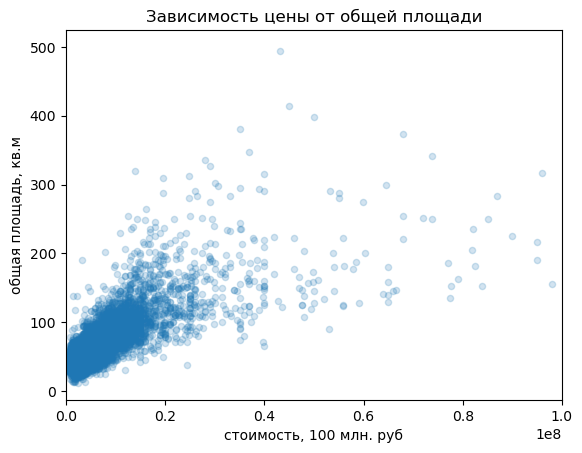

In [127]:
data_good_day.plot(x='last_price', y='total_area', kind='scatter', alpha=0.2)
plt.title('Зависимость цены от общей площади')
plt.xlabel('стоимость, 100 млн. руб')
plt.ylabel('общая площадь, кв.м')
plt.xlim(0,100000000)
plt.show()

Из полученного графика, видно что больше всего данных для квартир стоимостью до 20 млн.руб и площадью до 160 кв.м. Зависимость прямопропорциональная - чем больше площадь квартиры тем больше цена.

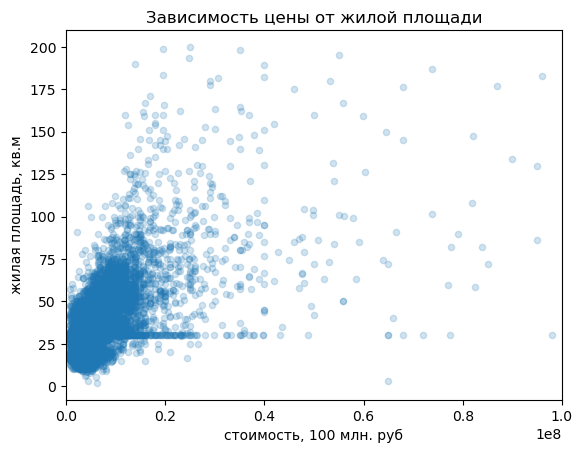

In [128]:
data_good_day.plot(x='last_price', y='living_area', kind='scatter', alpha=0.2)
plt.title('Зависимость цены от жилой площади')
plt.xlabel('стоимость, 100 млн. руб')
plt.ylabel('жилая площадь, кв.м')
plt.xlim(0,100000000)
plt.show()

Из полученного графика, видно что больше всего данных для квартир стоимостью до 20 млн.руб и жилой площадью до 75 кв.м. Зависимость прямопропорциональная - чем больше жилая площадь квартиры, тем больше цена.

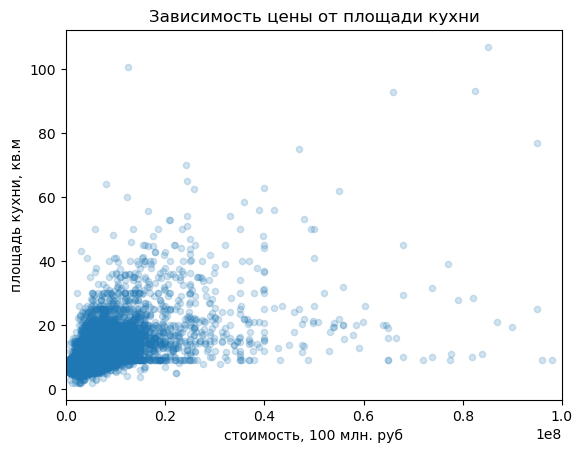

In [129]:
data_good_day.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.2)
plt.title('Зависимость цены от площади кухни')
plt.xlabel('стоимость, 100 млн. руб')
plt.ylabel('площадь кухни, кв.м')
plt.xlim(0,100000000)
plt.show()

Из полученного графика, видно что больше всего данных для квартир стоимостью до 20 млн.руб и площадью кухни до 20 кв.м. Зависимость прямопропорциональная - чем больше площадь кухне, тем больше цена.

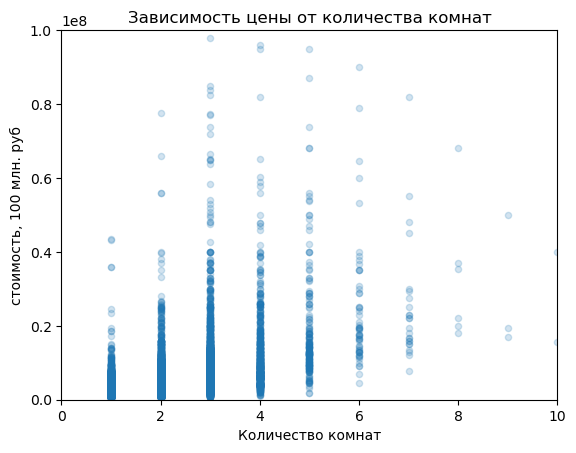

In [130]:
data_good_day.plot(x='rooms', y='last_price', kind='scatter', alpha=0.2)
plt.title('Зависимость цены от количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('стоимость, 100 млн. руб')
plt.xlim(0,10)
plt.ylim(0,100000000)
plt.show()

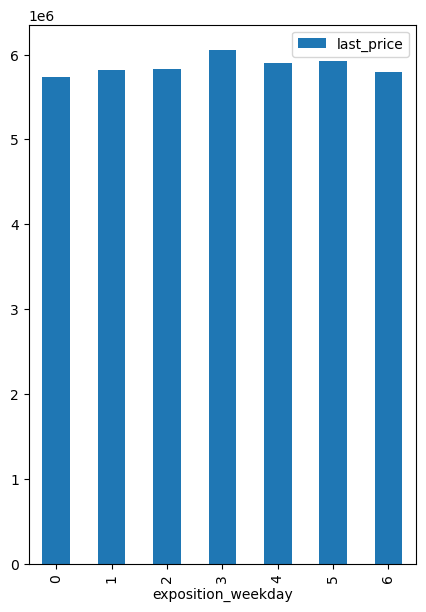

In [131]:
data_good_day.pivot_table(index='exposition_weekday', values='last_price', aggfunc='mean').plot.bar(figsize=(5, 7), legend=True)
plt.show()


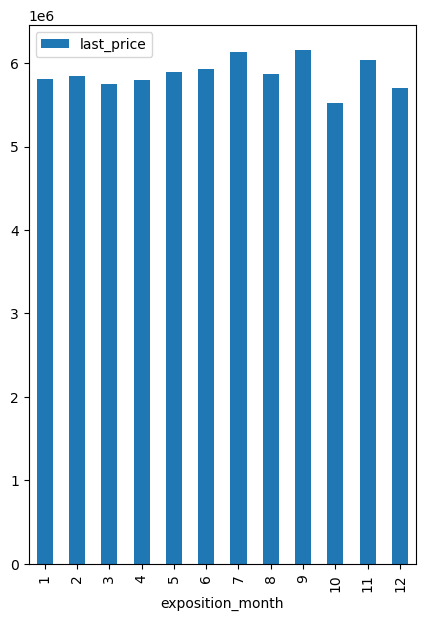

In [132]:
data_good_day.pivot_table(index='exposition_month', values='last_price', aggfunc='mean').plot.bar(figsize=(5, 7), legend=True)
plt.show()

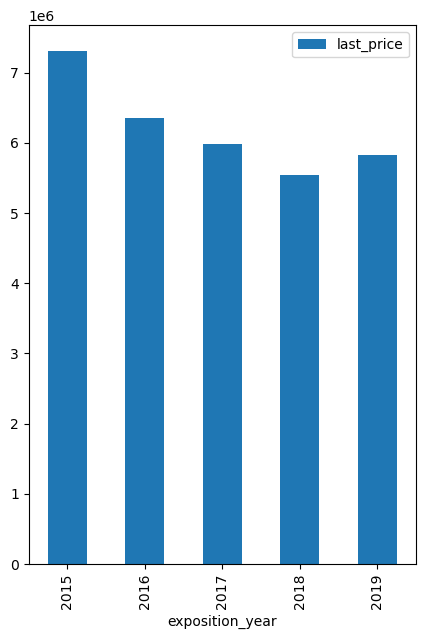

In [133]:
data_good_day.pivot_table(index='exposition_year', values='last_price', aggfunc='mean').plot.bar(figsize=(5, 7), legend=True)
plt.show()

Зависимость между датой размещения объявления (день недели, месяц, год) и стоимостью квартир есть, особенно это заметно для годов размещения. Из графиков видно, что наиболее дорогое объявление в четверг, в июле и сентябре, а также в 2015 году. Хотя в 2019 году наблюдается рост стоимости

Для определения влияния этажа на цену квартиры построим сводную таблицу

In [134]:
#создаем сводную таблицу
data_good_day_pivot = data_good_day.pivot_table(index='floor_category', values='last_price', aggfunc=['count', 'mean', 'median'])

#переименовываем столбцы
data_good_day_pivot.columns = ['count', 'mean', 'median']

#выводим сводную таблицу
display(data_good_day_pivot)

,count,mean,median
floor_category,,,
другой,13728,6.096850e+06,4654000
первый,2206,4.453227e+06,3800000
последний,2516,5.894614e+06,4200000


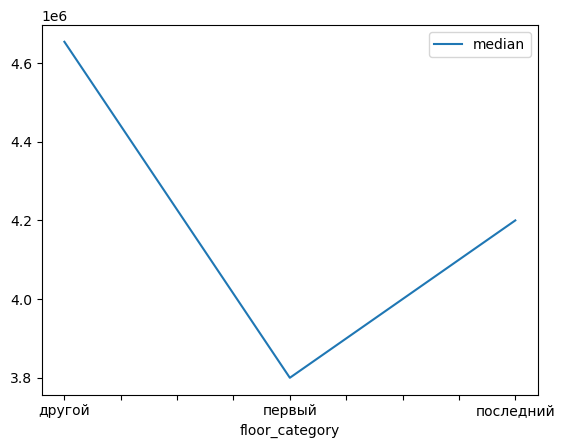

In [135]:
#построим зависимость
data_good_day_pivot.plot(y = 'median', legend=True)
plt.show()

Из графика видно, что медианное значение для квартир на первом этаже минимальное. Максимальное медианное значение стоимости квартир - для квартир отличных от первого и последнего этажа, типа "другие".

В целом можно сказать, что на стоимость квартиры больше всего влияет площадь квартиры (чем больше площадь, тем больше стоимость), а также место расположения квартиры в доме (стоимость квартиры меньше, если она расположена на 1 или последнем этаже, в отличие от других этажей)

#### Изучение средней цены квадратного метра в 10 населенных пунктах на наибольшим количеством объявлений

In [136]:
#ТОП 10 населенных пунктов с наибольшим числом объявлений
top_10_localities = data_good_day['locality_name'].value_counts().head(10)
display(top_10_localities)

locality_name
Санкт-Петербург      12254
поселок Мурино         489
Кудрово                385
поселок Шушары         383
Всеволожск             304
Колпино                293
поселок Парголово      283
Пушкин                 275
Гатчина                244
Выборг                 191
Name: count, dtype: int64

In [137]:
# Выведем среднюю цену за кв м по топ 10 населенным пунктам
top_10_localities_pivot = (
    data_good_day.query(
    'locality_name in @top_10_localities.index')
    .pivot_table(index='locality_name', values='price_square_meter')
)
top_10_localities_pivot.sort_values(by='price_square_meter', ascending=False)

,price_square_meter
locality_name,
Санкт-Петербург,110880.852659
Пушкин,101898.800674
Кудрово,94262.961783
поселок Парголово,89308.943374
поселок Мурино,85289.274117
поселок Шушары,77450.910154
Колпино,74768.674599
Всеволожск,68562.412384
Гатчина,68065.179645


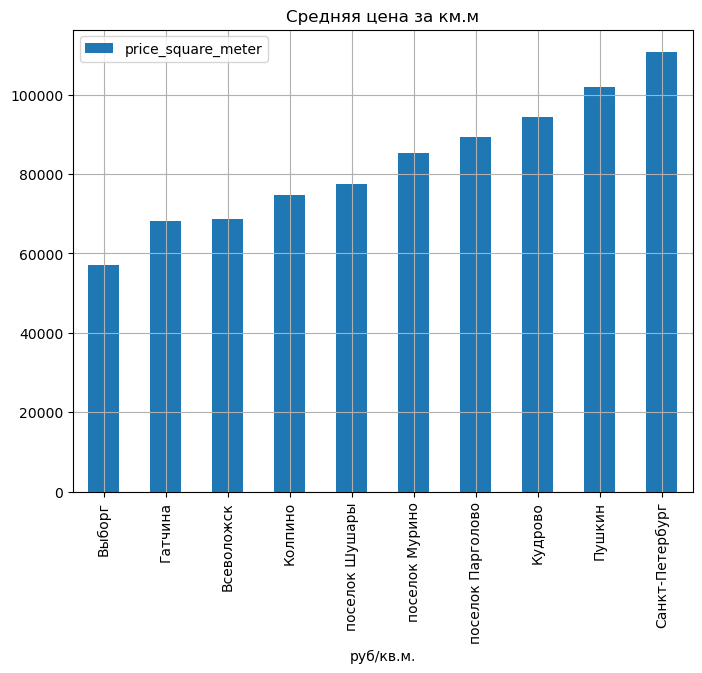

In [138]:
# Отобразим на графике среднюю цену квадратного метра в топ 10 населенных пунктах

top_10_localities_pivot.sort_values(by='price_square_meter').plot(kind='bar', legend=True, grid=True, figsize=(8, 6))

plt.title('Средняя цена за км.м')
plt.xlabel('руб/кв.м.')
plt.ylabel('')
plt.show()

Анализ показал, что стоимость одного квадратного метра (примерно 112 тыс.руб.) больше всего в Санкт-Петербурге, что довольно логично. Наименьшая цена за квадратный метр в Выборге (около 57 тыс.руб)

#### Определение стоимости квартир в Санкт-Петербурге в зависимости от расстояния до центра

Выделим из данных только данные о Санкт-Петербурге

In [139]:
df_spb = data_good_day.query('locality_name == "Санкт-Петербург"')


In [140]:
df_spb.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,price_square_meter,exposition_weekday,exposition_month,exposition_year,floor_category,city_centers_nearest_km
3,0,64900000,159.000000,2015-07-24,3,2.65,14,30.000000,9,False,False,False,9.1,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,другой,7.0
4,2,10000000,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой,8.0
9,18,5400000,61.000000,2017-02-26,3,2.50,9,43.599998,7,False,False,False,6.5,2,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,88524.590164,6,2,2017,другой,15.0
10,5,5050000,39.599998,2017-11-16,1,2.67,12,20.299999,3,False,False,False,8.5,0,Санкт-Петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0,127525.257439,3,11,2017,другой,14.0
15,16,4650000,39.000000,2017-11-18,1,2.65,14,20.500000,5,False,False,False,7.6,1,Санкт-Петербург,12900.0,14259.0,1.0,590.0,1.0,296.0,19.0,119230.769231,5,11,2017,другой,14.0


In [141]:
#Узнаем количество таких данных
len(df_spb)

12254

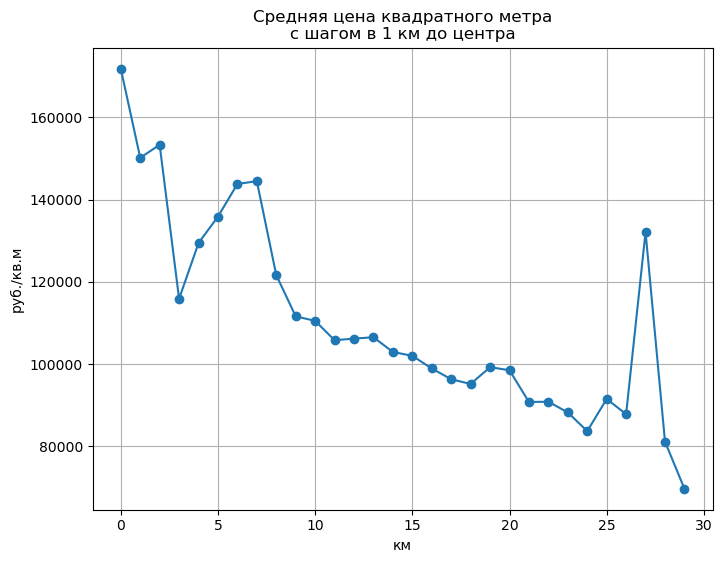

In [142]:
# Рассчитаем среднюю цену квадратного метра до центра
(
df_spb
    .pivot_table(index='city_centers_nearest_km', values='price_square_meter')
    .plot(marker='o', grid=True, figsize=(8, 6), legend=False)
)
plt.title('Средняя цена квадратного метра\nс шагом в 1 км до центра')
plt.xlabel('км')
plt.ylabel('руб./кв.м')
plt.show()

Из полученного графика видно, что чем ближе квартира к центру, тем она дороже (хотя в данных наблюдается некая нелинейность, которая вполне может быть обусловлена тем, что в центре Санкт-Петербурга исторически довольно много коммунальных квартир, которые расположены к центру довольно близко, но при этом не очень дорогие. И обратная ситуация на удалении примерно - 27 км, вполне возможно, что там расположено некое элитное дорогостоящее жилье, от того и "пик" в стоимости). 

### Общий вывод

На входе были получены данные сервиса Яндекс Недвижимость - архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах.

Как было установлено в задаче, была проведена обработка данных, изучены полученные закономерности в рамках предобработки, сформулированны соответствующие выводы.

По результатам проведенного исследовательского анализа можно сделать следующий вывод:
- Наибольшее влияние на стоимость квартиры оказывает её площадь.
Чем больше площадь квартиры, тем выше её стоимость. Также на стоимость квартиры влияет и количество комнат. Чем больше комнат, тем выше стоимость. На стоимость квартиры также влияет расстояние до центра города. Чем ближе квартира располагается к центру, тем выше ее стоимость. По результатам исследования приняли, что зона центра города распространяется на 8 км.

- Получили представление о типичном объекте недвижимости: квартира с 1 или 2 комнатами, 5-ти или 9-ти этажка (с квартирой с 1 по 5 этаж), общей площадью около 45 кв.м., площадью кухни около 9 кв.м, с высотой потолков 2,5-2,7 м, стоимостью около 3.5 млн.руб, расположенной на удалении от центра на расстоянии 12-15 км, от аэропорта на расстоянии 15-25 км, до ближайшего парка около 500 метров.

Также по результатам анализа установлено:

- Ожидаемое время продажи объекта недвижимости - от 45 до 231 день.
- Самые дорогие квартиры были опубликованы в 2015 году, потом этот показатель стал падать, однако в 2019 году снова наблюдается увеличение. Так же наблюдается легкая зависимость стоимости квартиры от публикации в середине недели (среда, четверг) и в середине года (июль-сентябрь).
- Самая высокая средняя стоимость квадратного метра в Санкт-Петербурге* - 112 тыс. руб./кв.м (Возглавляет топ-10 населенных пунктов по количеству объявлений).
- Самая низкая средняя стоимость квадратного метра в Выборге -57 тыс. руб./кв.м. (Замыкает топ-10 населенных пунктов по количеству объявлений).